In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.filter = filter

    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        # audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        # audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            # audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            # torch.from_numpy(audio_arr.copy()).float(),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        if len(data<15):
            return data  # If the data is too short, return it unfiltered
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        # Return the filtered data, maintaining the original shape of the input data
        return filter_data

class normalizer():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        id, adc1, adc2 = sample
        # audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[0]) / self.std[0]
        adc2 = (adc2 - self.mean[0]) / self.std[0]
        return id, adc1, adc2

# input_length = 512

# Path to the descriptor JSON file.
signal_descriptor_path = 'p2SamPhonemes_filtered_descriptor.json'
noise_descriptor_path = 'p2SamPhonemes_noise_descriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
signal_dataset = MemmapDataset(signal_descriptor_path, padding_handling="remove", filter=True)
noise_dataset = MemmapDataset(noise_descriptor_path, padding_handling="remove", filter=True)

transform = normalizer(mean=[signal_dataset.get("adc_mean")], std=[signal_dataset.get("adc_std")])

signal_dataset.transform = transform
noise_dataset.transform = transform
output_length = signal_dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = signal_dataset[1]
# print(f"\nWith ADC interpolation to length {input_length}:")
print("ADC1 shape:", sample[1].shape)
print("ADC2 shape:", sample[2].shape)

print(signal_dataset.descriptor["max_adc_len"])


Number of classes: 38
ADC1 shape: torch.Size([2399])
ADC2 shape: torch.Size([2399])
5199


In [2]:
import random
import torch
import numpy as np
from torch.utils.data import Dataset

class CompositeDataset(Dataset):
    def __init__(self, noise_dataset, signal_dataset, composite_length, n_signals=(1,3)):
        """
        Args:
            noise_dataset: Dataset for noise
            signal_dataset: Dataset for real signals
            composite_length (int): Length of the composite signal to be generated.
            n_signals (tuple) (optional): A tuple specifying the range of number of signals to combine.
                For example, (2, 3) means 2 or 3 signals will be combined.
        """
        self.noise_dataset = noise_dataset
        self.signal_dataset = signal_dataset
        self.composite_length = composite_length
        self.n_signals = n_signals
        self.num_signal_classes = signal_dataset.get_Nclasses() 
        self.total_classes = self.num_signal_classes + 1  # +1 for noise class
    
    def __len__(self):
        # You can set this arbitrarily. For illustration, 
        # we combine lengths of noise and signal dataset:
        return (len(self.noise_dataset) + len(self.signal_dataset))//self.n_signals[1]  # This is just a heuristic to define length
    
    def get_N_classes(self):
        return self.num_signal_classes + 2

    def get_composite_length(self):
        return self.composite_length

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        For example, dataset.id_to_dataset(1) returns the associated dataset name.
        """
        if id < 0 or id >= self.num_signal_classes:
            return "Noise"
        return self.signal_dataset.id_to_dataset(id)

    def __getitem__(self, idx):
        """
        Dynamically builds one artificial segment (only ADC).
        """
        # 1. Decide how many signal chunks to place in this segment
        n_sigs_needed = random.randint(*self.n_signals)

        # 2. Prepare empty arrays for the final output of shape [composite_length]
        adc1_full  = np.zeros(self.composite_length, dtype=np.float32)
        adc2_full  = np.zeros(self.composite_length, dtype=np.float32)
        
        # 3. Prepare an integer label array of shape [composite_length]
        label_full = np.zeros(self.composite_length, dtype=np.int64)  
        
        current_pos = 0
        signals_used = 0

        # Decide if we start with noise or signal
        place_signal_first = (random.random() < 0.5)
        
        # 4. Alternate placing noise / signal until we exhaust n_sigs_needed
        while current_pos < self.composite_length and signals_used < n_sigs_needed:
            if place_signal_first:
                # (a) Grab a random signal
                sig_idx = random.randint(0, len(self.signal_dataset)-1)
                s_id, s_adc1, s_adc2 = self.signal_dataset[sig_idx]
                
                # (b) Decide how big the chunk is: place as much of the signal as we can
                sig_length = min(len(s_adc1), self.composite_length - current_pos)
                
                # (c) Copy into the full array
                adc1_full[current_pos : current_pos + sig_length]  = s_adc1[:sig_length]
                adc2_full[current_pos : current_pos + sig_length]  = s_adc2[:sig_length]
                label_full[current_pos : current_pos + sig_length] = s_id
                
                current_pos += sig_length
                signals_used += 1
            else:
                # (d) Place a noise chunk
                noise_idx = random.randint(0, len(self.noise_dataset)-1)
                _, n_adc1, n_adc2 = self.noise_dataset[noise_idx]

                # Example: pick a random noise length in some range
                low = self.composite_length // min(self.n_signals)
                high = self.composite_length // max(self.n_signals)
                n_length = random.randint(high, low)
                # clip to space left in the array
                n_length = min(n_length, self.composite_length - current_pos)
                # clip to the noise sample length
                n_length = min(n_length, len(n_adc1))

                adc1_full[current_pos : current_pos + n_length]  = n_adc1[:n_length]
                adc2_full[current_pos : current_pos + n_length]  = n_adc2[:n_length]
                label_full[current_pos : current_pos + n_length] = self.num_signal_classes + 1  # noise label

                current_pos += n_length
            
            # flip noise ↔ signal
            place_signal_first = not place_signal_first

        # 5. If we've placed all required signals but still have space, fill the rest with noise
        while current_pos < self.composite_length:
            # place a noise chunk
            noise_idx = random.randint(0, len(self.noise_dataset)-1)
            _, n_adc1, n_adc2 = self.noise_dataset[noise_idx]
            remaining = self.composite_length - current_pos
            n_length = min(remaining, len(n_adc1))

            adc1_full[current_pos : current_pos + n_length]  = n_adc1[:n_length]
            adc2_full[current_pos : current_pos + n_length]  = n_adc2[:n_length]
            label_full[current_pos : current_pos + n_length] = self.num_signal_classes + 1

            current_pos += n_length

        # 6. Convert to torch tensors (optionally apply transforms)
        adc1_tensor  = torch.from_numpy(adc1_full)
        adc2_tensor  = torch.from_numpy(adc2_full)
        label_tensor = torch.from_numpy(label_full)
        
        return adc1_tensor, adc2_tensor, label_tensor


# Example usage:
seq_length = 16000  # Length of the composite sequence
dataset = CompositeDataset(noise_dataset, signal_dataset,
                           composite_length=seq_length, n_signals=(3, 5))

print("Composite Dataset Length:", len(dataset))

# Test the CompositeDataset
sample = dataset[0]
print("Sample shapes from Composite Dataset:")
print("ADC1 shape:", sample[0].shape)
print("ADC2 shape:", sample[1].shape)
print("Label shape:", sample[2].shape)


Composite Dataset Length: 893
Sample shapes from Composite Dataset:
ADC1 shape: torch.Size([16000])
ADC2 shape: torch.Size([16000])
Label shape: torch.Size([16000])


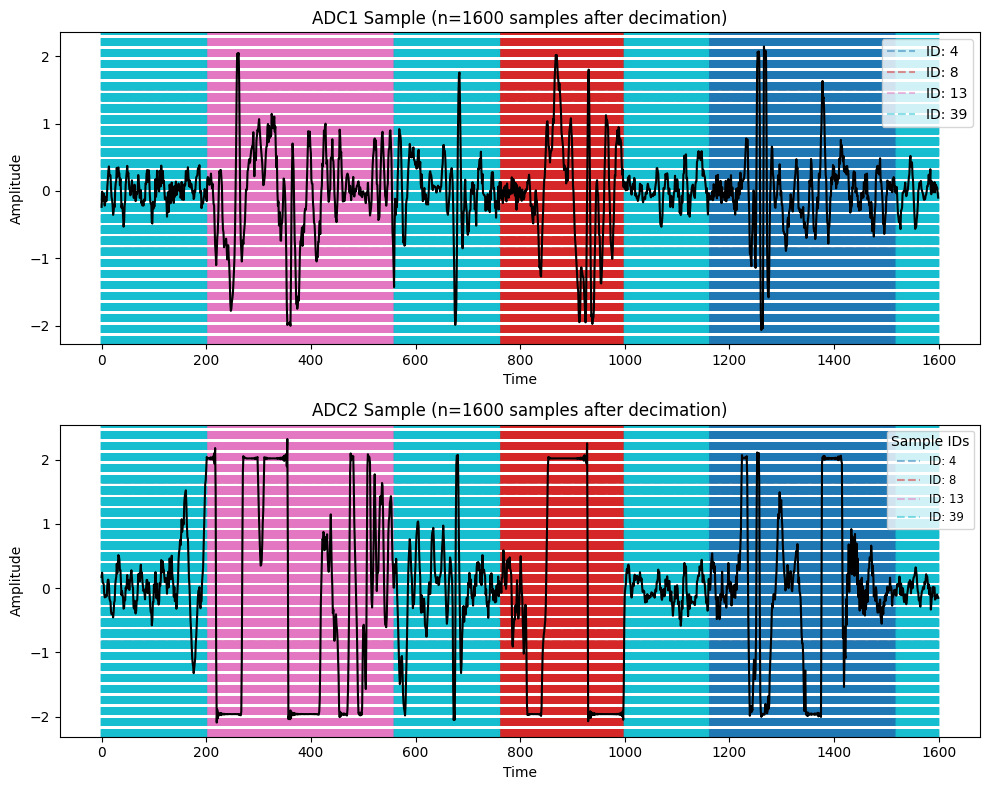

In [3]:
from scipy.signal import decimate

import matplotlib.pyplot as plt

n_decimate = 10  # Decimation factor

rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

adc1, adc2, sample_id = sample  # unpack the tuple

# Decimate the signals for display
adc1_decimated = decimate(adc1.numpy(), n_decimate, zero_phase=True)
adc2_decimated = decimate(adc2.numpy(), n_decimate, zero_phase=True)
sample_id_decimated = decimate(sample_id.numpy(), n_decimate, zero_phase=True, ftype='iir')

# Create a figure with two subplots for ADC1 and ADC2.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Add colored vertical lines for the sample_id
unique_ids = torch.unique(sample_id)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ids)))  # Generate distinct colors for each unique ID

for unique_id, color in zip(unique_ids, colors):
    indices = (sample_id == unique_id).nonzero(as_tuple=True)[0].numpy()  # Get indices for the current ID
    indices_decimated = indices // n_decimate  # Adjust indices for decimation
    for idx in indices_decimated:
        axs[0].axvline(x=idx, color=color, linestyle='--', alpha=0.5, label=f"ID: {unique_id.item()}")
        axs[1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

# Add legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
axs[0].legend(by_label.values(), by_label.keys(), loc='upper right')
axs[0].plot(adc1_decimated, color='black', label='ADC1')
axs[0].set_title(f"ADC1 Sample (n={len(adc1_decimated)} samples after decimation)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small', title="Sample IDs")
axs[1].plot(adc2_decimated, color='black', label='ADC2')
axs[1].set_title(f"ADC2 Sample (n={len(adc2_decimated)} samples after decimation)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [4]:
from torch import nn
import math

class SinusoidalPositionalEncoding(nn.Module):
    """
    Implements the classic sinusoidal positional encoding as described in the 
    "Attention is All You Need" paper (Vaswani et al., 2017).
    """
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        
        # Create a long enough P x D matrix of sinusoidal signals
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # [d_model/2]
        
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        # Even indices: 2i
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices: 2i+1
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer so it doesn't get updated during backprop
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x is assumed to be of shape [batch_size, seq_len, d_model].
        We want to add positional encoding to each position in the sequence.
        """
        seq_len = x.size(1)  # how many tokens in the sequence dimension
        # Add the positional embedding up to seq_len
        pos_emb = self.pe[:seq_len, :]  # shape [seq_len, d_model]
        # We need shape to match x: [B, seq_len, d_model]
        return x + pos_emb.unsqueeze(0)


class V1dTransformer(nn.Module):
    def __init__(self, 
                 input_dim,
                 output_dim,
                 max_length,
                 input_kern = 16,  # Kernel size for the initial Conv1d layer
                 nhead=8, 
                 num_encoder_layers=6, 
                 dim_feedforward=512, 
                 dropout=0.1):
        super(V1dTransformer, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_kern = input_kern  # Kernel size for the initial Conv1d layer
        self.stride = input_kern   # Stride for the Conv1d layer, typically half of kernel size
        
        self.conv = nn.Conv1d(input_dim, dim_feedforward, kernel_size=self.input_kern, stride=self.stride)
        # self.posencoding = nn.Embedding(10000, dim_feedforward)  # Positional encoding for up to 1000 positions
        self.pos_encoding = SinusoidalPositionalEncoding(dim_feedforward, max_len=(max_length-self.input_kern)//self.stride + 1)  # Adjust max_len based on stride
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim_feedforward,
                nhead=nhead,
                dim_feedforward=dim_feedforward*2,
                dropout=dropout,
                batch_first=True  # Set to True to match the input shape (batch_size, seq_length, d_model
            ),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(dim_feedforward, output_dim)

        # self.special_token = nn.Embedding(1, dim_feedforward)  # Special token embedding for the special token
    
    def forward(self, x):
        """
        x: shape [B, 2, T]  (two ADC channels)
        special_token_positions_batch: list of lists of integers
        - E.g. [[2, 10], [0, 3, 5], ..., [1]] 
        - where each sub-list is for one sample in the batch.
        """

        # 1) Convolution => [B, dim_feedforward, new_seq_len]
        x = self.conv(x)
        
        # 2) Permute => [B, new_seq_len, dim_feedforward]
        x = x.permute(0, 2, 1)

        # 4) Add positional encoding => [B, new_seq_len, dim_feedforward]
        x = self.pos_encoding(x)
        
        # 5) Transformer => [B, new_seq_len, dim_feedforward]
        x = self.transformer_encoder(x)

        # 6) Final projection => [B, new_seq_len, output_dim]
        x = self.fc_out(x)

        return x


dummy_input = torch.randn(4,2, seq_length)


model = V1dTransformer(
    input_dim=2,  # Two input channels: adc1 and adc2
    output_dim=dataset.get_N_classes(),  # Number of classes
    max_length=seq_length,  # Maximum sequence length
    input_kern=32,  # Kernel size for the initial Conv1d layer
    nhead=4, 
    num_encoder_layers=4, 
    dim_feedforward=256, 
    dropout=0.1
)


output = model(dummy_input)

print("Output shape:", output.shape)
print("\n\n")
print(model)

Output shape: torch.Size([4, 500, 40])



V1dTransformer(
  (conv): Conv1d(2, 256, kernel_size=(32,), stride=(32,))
  (pos_encoding): SinusoidalPositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=256, out_features=40, bias=True)
)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import random


def train_epoch(
    model,
    dataloader,
    epochs,
    optimizer,
    scheduler,
    loss_func,
    device='cpu',
    min_special_tokens=100,
    max_special_tokens=500,
    verbose=1
):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        total_correct = 0
        total_special = 0
        num_batches = 0
        
        # Loop over data
        iterator = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", disable=(verbose==0))
        for (adc1, adc2, ids) in iterator:
            # Move to device
            adc1 = adc1.to(device)  # shape [B, T]
            adc2 = adc2.to(device)  # shape [B, T]
            ids = ids.to(device)    # shape [B, T]
            ids = ids[:,::model.input_kern]  # Downsample ids to match the new sequence length after Conv1d
            # print(ids.min(), ids.max(), ids.shape)
            # -------------------------------------------------
            # 2) Stack ADC channels => shape [B, 2, T]
            # -------------------------------------------------
            adc = torch.stack((adc1, adc2), dim=1)  # [B, 2, T]
            adc = adc+torch.randn_like(adc) * 0.02  # Adding a small amount of noise for robustness
            
            # -------------------------------------------------
            # 3) Forward pass
            # -------------------------------------------------
            logits = model(adc)  
            # shape [B, seq_len_after_conv, output_dim]
            # -------------------------------------------------
            # 5) Compute classification loss
            # -------------------------------------------------
            loss = loss_func(logits.permute(0,2,1), ids)
            
            # 6) Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 7) Accuracy on these special tokens
            with torch.no_grad():
                pred = logits.argmax(dim=2)  # [N]
                correct = (pred == ids).sum().item()
            
            total_loss += loss.item()
            total_correct += correct
            total_special += logits.size(0)* logits.size(1)  # total number of special tokens processed
            num_batches += 1

            if verbose:
                iterator.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{100.0 * correct / (logits.size(0)*logits.size(1)):.2f}%",
                })
        scheduler.step()
        # End of epoch
        avg_loss = total_loss / max(num_batches, 1)
        if total_special > 0:
            accuracy = 100.0 * total_correct / total_special
        else:
            accuracy = 0.0
        
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} => Loss: {avg_loss:.4f}, Special-Token Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy



In [6]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.8  # 80% for training
val_ratio = 0.2

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#! Create DataLoader instances for training and validation sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([[-0.3633, -0.3702, -0.3534,  ..., -0.3692, -0.3278, -0.3800],
        [-0.0110,  0.7810,  1.0310,  ..., -0.2108, -0.1507, -0.3839],
        [-0.7539, -0.8257, -0.3967,  ...,  2.0414,  2.0414,  2.0414],
        ...,
        [-0.0720, -0.0553, -0.0887,  ...,  0.1011,  0.0638,  0.0884],
        [-0.2757, -0.2472, -0.3042,  ..., -0.1379, -0.1724, -0.1074],
        [ 0.1336,  0.1346,  0.8745,  ..., -0.1330,  0.0362,  0.0185]])
ADC1 shape: torch.Size([64, 16000])
ADC2 shape: torch.Size([64, 16000])
Batch 2:
IDs: tensor([[-0.1035, -0.1074,  0.1789,  ..., -0.2462,  0.0992, -0.2098],
        [ 0.2448,  0.3245,  0.3412,  ..., -0.3770, -0.3908, -0.2521],
        [ 0.4052,  0.3137,  0.3038,  ..., -0.2157, -0.1143, -0.2442],
        ...,
        [-0.2088, -0.3731, -0.3761,  ..., -0.2432, -0.1950, -0.2058],
        [-0.2688, -0.1940, -0.2117,  ..., -0.1301, -0.2049, -0.1104],
        [ 0.7023,  0.7348,  1.3143,  ...,  0.1927,  0.1730,  0.2350]])
ADC1 shape: torch.Size([64, 1600

In [7]:
# !wandb login

In [8]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [9]:
TOTAL_EPOCHS = 512
PER_EPOCH = 1

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
weights = torch.ones(dataset.get_N_classes())  # Weight for each class
weights[-1] = 1/(dataset.get_N_classes()*2)  # Give less weight to the noise class
criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)  # Use label smoothing for better generalization
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
# scheduler = None
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", global_device)
verbosity = 1
criterion = criterion.to(global_device)

Using device: cuda:0


In [ ]:
# the actual trainign loop
train_stats = []
test_stats = []
for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res = train_epoch(model, 
                     train_loader, 
                     epochs=PER_EPOCH, 
                     optimizer=optimizer,
                     scheduler=scheduler,
                    loss_func=criterion,
                     device=global_device,
                     min_special_tokens=100,
                     max_special_tokens=1000,
                     verbose=epoch % 10 == 0 
                     )
    train_stats.append(res)
    test_stats.append(res)



TOTAL Epochs:   0%|          | 1/512 [00:01<14:38,  1.72s/it]

Epoch 1/1 => Loss: 4.0378, Special-Token Accuracy: 1.81%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.02it/s, loss=3.9443, acc=1.54%]


Epoch 1/1 => Loss: 3.9364, Special-Token Accuracy: 1.84%


TOTAL Epochs:   1%|          | 3/512 [00:02<05:44,  1.48it/s]

Epoch 1/1 => Loss: 3.9330, Special-Token Accuracy: 1.88%


TOTAL Epochs:   1%|          | 4/512 [00:03<07:26,  1.14it/s]

Epoch 1/1 => Loss: 3.9064, Special-Token Accuracy: 1.92%


TOTAL Epochs:   1%|          | 5/512 [00:04<08:30,  1.01s/it]

Epoch 1/1 => Loss: 3.8949, Special-Token Accuracy: 2.03%


TOTAL Epochs:   1%|          | 6/512 [00:06<09:11,  1.09s/it]

Epoch 1/1 => Loss: 3.8813, Special-Token Accuracy: 1.97%


TOTAL Epochs:   1%|▏         | 7/512 [00:07<09:37,  1.14s/it]

Epoch 1/1 => Loss: 3.8443, Special-Token Accuracy: 2.94%


TOTAL Epochs:   2%|▏         | 8/512 [00:08<09:57,  1.19s/it]

Epoch 1/1 => Loss: 3.8271, Special-Token Accuracy: 2.82%


TOTAL Epochs:   2%|▏         | 9/512 [00:09<10:09,  1.21s/it]

Epoch 1/1 => Loss: 3.8269, Special-Token Accuracy: 2.95%


TOTAL Epochs:   2%|▏         | 10/512 [00:11<10:16,  1.23s/it]

Epoch 1/1 => Loss: 3.8182, Special-Token Accuracy: 2.74%


TOTAL Epochs:   2%|▏         | 11/512 [00:12<10:21,  1.24s/it]

Epoch 1/1 => Loss: 3.8242, Special-Token Accuracy: 3.13%


TOTAL Epochs:   2%|▏         | 12/512 [00:13<10:23,  1.25s/it]

Epoch 1/1 => Loss: 3.8294, Special-Token Accuracy: 2.80%


TOTAL Epochs:   3%|▎         | 13/512 [00:15<10:29,  1.26s/it]

Epoch 1/1 => Loss: 3.7657, Special-Token Accuracy: 3.99%


TOTAL Epochs:   3%|▎         | 14/512 [00:16<10:29,  1.26s/it]

Epoch 1/1 => Loss: 3.7569, Special-Token Accuracy: 3.77%


TOTAL Epochs:   3%|▎         | 15/512 [00:17<10:30,  1.27s/it]

Epoch 1/1 => Loss: 3.6285, Special-Token Accuracy: 5.54%


TOTAL Epochs:   3%|▎         | 16/512 [00:18<10:30,  1.27s/it]

Epoch 1/1 => Loss: 3.5345, Special-Token Accuracy: 6.61%


TOTAL Epochs:   3%|▎         | 17/512 [00:20<10:30,  1.27s/it]

Epoch 1/1 => Loss: 3.4558, Special-Token Accuracy: 7.53%


TOTAL Epochs:   4%|▎         | 18/512 [00:21<10:29,  1.27s/it]

Epoch 1/1 => Loss: 3.3273, Special-Token Accuracy: 9.65%


TOTAL Epochs:   4%|▎         | 19/512 [00:22<10:27,  1.27s/it]

Epoch 1/1 => Loss: 3.2346, Special-Token Accuracy: 10.14%


TOTAL Epochs:   4%|▍         | 20/512 [00:23<10:26,  1.27s/it]

Epoch 1/1 => Loss: 3.1653, Special-Token Accuracy: 12.07%


TOTAL Epochs:   4%|▍         | 21/512 [00:25<10:25,  1.27s/it]

Epoch 1/1 => Loss: 3.1067, Special-Token Accuracy: 12.34%


TOTAL Epochs:   4%|▍         | 22/512 [00:26<10:24,  1.27s/it]

Epoch 1/1 => Loss: 3.1273, Special-Token Accuracy: 12.73%


TOTAL Epochs:   4%|▍         | 23/512 [00:27<10:22,  1.27s/it]

Epoch 1/1 => Loss: 3.0676, Special-Token Accuracy: 13.21%


TOTAL Epochs:   5%|▍         | 24/512 [00:29<10:21,  1.27s/it]

Epoch 1/1 => Loss: 3.0099, Special-Token Accuracy: 14.44%


TOTAL Epochs:   5%|▍         | 25/512 [00:30<10:20,  1.27s/it]

Epoch 1/1 => Loss: 2.9483, Special-Token Accuracy: 15.58%


TOTAL Epochs:   5%|▌         | 26/512 [00:31<10:19,  1.27s/it]

Epoch 1/1 => Loss: 2.9469, Special-Token Accuracy: 16.49%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.31it/s, loss=2.8171, acc=18.75%]


Epoch 1/1 => Loss: 2.8960, Special-Token Accuracy: 16.97%


TOTAL Epochs:   5%|▌         | 28/512 [00:32<06:44,  1.20it/s]

Epoch 1/1 => Loss: 2.8470, Special-Token Accuracy: 18.25%


TOTAL Epochs:   6%|▌         | 29/512 [00:33<07:37,  1.06it/s]

Epoch 1/1 => Loss: 2.8291, Special-Token Accuracy: 18.74%


TOTAL Epochs:   6%|▌         | 30/512 [00:34<08:17,  1.03s/it]

Epoch 1/1 => Loss: 2.7662, Special-Token Accuracy: 19.93%


TOTAL Epochs:   6%|▌         | 31/512 [00:36<08:50,  1.10s/it]

Epoch 1/1 => Loss: 2.7260, Special-Token Accuracy: 20.79%


TOTAL Epochs:   6%|▋         | 32/512 [00:37<09:12,  1.15s/it]

Epoch 1/1 => Loss: 2.6866, Special-Token Accuracy: 21.91%


TOTAL Epochs:   6%|▋         | 33/512 [00:38<09:28,  1.19s/it]

Epoch 1/1 => Loss: 2.6912, Special-Token Accuracy: 21.94%


TOTAL Epochs:   7%|▋         | 34/512 [00:39<09:41,  1.22s/it]

Epoch 1/1 => Loss: 2.6259, Special-Token Accuracy: 23.60%


TOTAL Epochs:   7%|▋         | 35/512 [00:41<09:49,  1.23s/it]

Epoch 1/1 => Loss: 2.5853, Special-Token Accuracy: 24.84%


TOTAL Epochs:   7%|▋         | 36/512 [00:42<09:53,  1.25s/it]

Epoch 1/1 => Loss: 2.5970, Special-Token Accuracy: 24.78%


TOTAL Epochs:   7%|▋         | 37/512 [00:43<09:56,  1.26s/it]

Epoch 1/1 => Loss: 2.5527, Special-Token Accuracy: 25.52%


TOTAL Epochs:   7%|▋         | 38/512 [00:45<10:00,  1.27s/it]

Epoch 1/1 => Loss: 2.5396, Special-Token Accuracy: 25.64%


TOTAL Epochs:   8%|▊         | 39/512 [00:46<10:01,  1.27s/it]

Epoch 1/1 => Loss: 2.5353, Special-Token Accuracy: 26.58%


TOTAL Epochs:   8%|▊         | 40/512 [00:47<10:02,  1.28s/it]

Epoch 1/1 => Loss: 2.5053, Special-Token Accuracy: 26.62%


TOTAL Epochs:   8%|▊         | 41/512 [00:48<10:01,  1.28s/it]

Epoch 1/1 => Loss: 2.7622, Special-Token Accuracy: 20.88%


TOTAL Epochs:   8%|▊         | 42/512 [00:50<10:01,  1.28s/it]

Epoch 1/1 => Loss: 2.8063, Special-Token Accuracy: 19.48%


TOTAL Epochs:   8%|▊         | 43/512 [00:51<10:00,  1.28s/it]

Epoch 1/1 => Loss: 2.7840, Special-Token Accuracy: 20.47%


TOTAL Epochs:   9%|▊         | 44/512 [00:52<09:59,  1.28s/it]

Epoch 1/1 => Loss: 2.6962, Special-Token Accuracy: 22.20%


TOTAL Epochs:   9%|▉         | 45/512 [00:54<09:57,  1.28s/it]

Epoch 1/1 => Loss: 2.6804, Special-Token Accuracy: 23.40%


TOTAL Epochs:   9%|▉         | 46/512 [00:55<09:57,  1.28s/it]

Epoch 1/1 => Loss: 2.6426, Special-Token Accuracy: 24.51%


TOTAL Epochs:   9%|▉         | 47/512 [00:56<09:56,  1.28s/it]

Epoch 1/1 => Loss: 2.5847, Special-Token Accuracy: 25.32%


TOTAL Epochs:   9%|▉         | 48/512 [00:57<09:55,  1.28s/it]

Epoch 1/1 => Loss: 2.5808, Special-Token Accuracy: 25.64%


TOTAL Epochs:  10%|▉         | 49/512 [00:59<09:54,  1.29s/it]

Epoch 1/1 => Loss: 2.5964, Special-Token Accuracy: 25.24%


TOTAL Epochs:  10%|▉         | 50/512 [01:00<09:54,  1.29s/it]

Epoch 1/1 => Loss: 2.5460, Special-Token Accuracy: 27.46%


TOTAL Epochs:  10%|▉         | 51/512 [01:01<09:54,  1.29s/it]

Epoch 1/1 => Loss: 2.4693, Special-Token Accuracy: 28.52%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.35it/s, loss=2.3106, acc=32.64%]


Epoch 1/1 => Loss: 2.4747, Special-Token Accuracy: 28.39%


TOTAL Epochs:  10%|█         | 53/512 [01:02<06:28,  1.18it/s]

Epoch 1/1 => Loss: 2.4604, Special-Token Accuracy: 29.46%


TOTAL Epochs:  11%|█         | 54/512 [01:03<07:20,  1.04it/s]

Epoch 1/1 => Loss: 2.3584, Special-Token Accuracy: 32.13%


TOTAL Epochs:  11%|█         | 55/512 [01:05<07:58,  1.05s/it]

Epoch 1/1 => Loss: 2.2973, Special-Token Accuracy: 32.58%


TOTAL Epochs:  11%|█         | 56/512 [01:06<08:27,  1.11s/it]

Epoch 1/1 => Loss: 2.3053, Special-Token Accuracy: 33.86%


TOTAL Epochs:  11%|█         | 57/512 [01:07<08:48,  1.16s/it]

Epoch 1/1 => Loss: 2.2828, Special-Token Accuracy: 33.81%


TOTAL Epochs:  11%|█▏        | 58/512 [01:08<09:08,  1.21s/it]

Epoch 1/1 => Loss: 2.2089, Special-Token Accuracy: 36.49%


TOTAL Epochs:  12%|█▏        | 59/512 [01:10<09:17,  1.23s/it]

Epoch 1/1 => Loss: 2.1548, Special-Token Accuracy: 38.24%


TOTAL Epochs:  12%|█▏        | 60/512 [01:11<09:27,  1.26s/it]

Epoch 1/1 => Loss: 2.0880, Special-Token Accuracy: 38.07%


TOTAL Epochs:  12%|█▏        | 61/512 [01:12<09:30,  1.27s/it]

Epoch 1/1 => Loss: 2.1069, Special-Token Accuracy: 38.84%


TOTAL Epochs:  12%|█▏        | 62/512 [01:14<09:32,  1.27s/it]

Epoch 1/1 => Loss: 2.1039, Special-Token Accuracy: 37.53%


TOTAL Epochs:  12%|█▏        | 63/512 [01:15<09:34,  1.28s/it]

Epoch 1/1 => Loss: 2.1160, Special-Token Accuracy: 39.10%


TOTAL Epochs:  12%|█▎        | 64/512 [01:16<09:34,  1.28s/it]

Epoch 1/1 => Loss: 2.0612, Special-Token Accuracy: 38.73%


TOTAL Epochs:  13%|█▎        | 65/512 [01:18<09:34,  1.29s/it]

Epoch 1/1 => Loss: 2.0493, Special-Token Accuracy: 40.57%


TOTAL Epochs:  13%|█▎        | 66/512 [01:19<09:34,  1.29s/it]

Epoch 1/1 => Loss: 2.0236, Special-Token Accuracy: 40.20%


TOTAL Epochs:  13%|█▎        | 67/512 [01:20<09:33,  1.29s/it]

Epoch 1/1 => Loss: 1.9889, Special-Token Accuracy: 43.03%


TOTAL Epochs:  13%|█▎        | 68/512 [01:21<09:33,  1.29s/it]

Epoch 1/1 => Loss: 1.9517, Special-Token Accuracy: 43.58%


TOTAL Epochs:  13%|█▎        | 69/512 [01:23<09:32,  1.29s/it]

Epoch 1/1 => Loss: 1.8602, Special-Token Accuracy: 44.46%


TOTAL Epochs:  14%|█▎        | 70/512 [01:24<09:32,  1.29s/it]

Epoch 1/1 => Loss: 1.8812, Special-Token Accuracy: 45.71%


TOTAL Epochs:  14%|█▍        | 71/512 [01:25<09:30,  1.29s/it]

Epoch 1/1 => Loss: 1.8793, Special-Token Accuracy: 44.34%


TOTAL Epochs:  14%|█▍        | 72/512 [01:27<09:29,  1.29s/it]

Epoch 1/1 => Loss: 1.8491, Special-Token Accuracy: 45.22%


TOTAL Epochs:  14%|█▍        | 73/512 [01:28<09:28,  1.30s/it]

Epoch 1/1 => Loss: 1.8273, Special-Token Accuracy: 46.32%


TOTAL Epochs:  14%|█▍        | 74/512 [01:29<09:27,  1.30s/it]

Epoch 1/1 => Loss: 1.8023, Special-Token Accuracy: 47.16%


TOTAL Epochs:  15%|█▍        | 75/512 [01:30<09:24,  1.29s/it]

Epoch 1/1 => Loss: 1.7910, Special-Token Accuracy: 46.86%


TOTAL Epochs:  15%|█▍        | 76/512 [01:32<09:22,  1.29s/it]

Epoch 1/1 => Loss: 1.7592, Special-Token Accuracy: 49.19%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.06it/s, loss=1.7677, acc=48.54%]


Epoch 1/1 => Loss: 1.7193, Special-Token Accuracy: 49.68%


TOTAL Epochs:  15%|█▌        | 78/512 [01:32<06:05,  1.19it/s]

Epoch 1/1 => Loss: 1.6983, Special-Token Accuracy: 52.02%


TOTAL Epochs:  15%|█▌        | 79/512 [01:34<06:52,  1.05it/s]

Epoch 1/1 => Loss: 1.6688, Special-Token Accuracy: 49.78%


TOTAL Epochs:  16%|█▌        | 80/512 [01:35<07:29,  1.04s/it]

Epoch 1/1 => Loss: 1.6600, Special-Token Accuracy: 51.52%


TOTAL Epochs:  16%|█▌        | 81/512 [01:36<07:57,  1.11s/it]

Epoch 1/1 => Loss: 1.6257, Special-Token Accuracy: 52.60%


TOTAL Epochs:  16%|█▌        | 82/512 [01:38<08:17,  1.16s/it]

Epoch 1/1 => Loss: 1.6157, Special-Token Accuracy: 53.09%


TOTAL Epochs:  16%|█▌        | 83/512 [01:39<08:32,  1.19s/it]

Epoch 1/1 => Loss: 1.5915, Special-Token Accuracy: 53.11%


TOTAL Epochs:  16%|█▋        | 84/512 [01:40<08:42,  1.22s/it]

Epoch 1/1 => Loss: 1.5638, Special-Token Accuracy: 54.22%


TOTAL Epochs:  17%|█▋        | 85/512 [01:41<08:51,  1.24s/it]

Epoch 1/1 => Loss: 1.5698, Special-Token Accuracy: 54.89%


TOTAL Epochs:  17%|█▋        | 86/512 [01:43<08:56,  1.26s/it]

Epoch 1/1 => Loss: 1.5703, Special-Token Accuracy: 54.39%


TOTAL Epochs:  17%|█▋        | 87/512 [01:44<08:57,  1.26s/it]

Epoch 1/1 => Loss: 1.5357, Special-Token Accuracy: 54.88%


TOTAL Epochs:  17%|█▋        | 88/512 [01:45<08:59,  1.27s/it]

Epoch 1/1 => Loss: 1.5234, Special-Token Accuracy: 56.30%


TOTAL Epochs:  17%|█▋        | 89/512 [01:47<08:59,  1.28s/it]

Epoch 1/1 => Loss: 1.4811, Special-Token Accuracy: 56.54%


TOTAL Epochs:  18%|█▊        | 90/512 [01:48<09:00,  1.28s/it]

Epoch 1/1 => Loss: 1.4886, Special-Token Accuracy: 56.91%


TOTAL Epochs:  18%|█▊        | 91/512 [01:49<08:59,  1.28s/it]

Epoch 1/1 => Loss: 1.4711, Special-Token Accuracy: 57.64%


TOTAL Epochs:  18%|█▊        | 92/512 [01:50<08:59,  1.28s/it]

Epoch 1/1 => Loss: 1.4710, Special-Token Accuracy: 57.72%


TOTAL Epochs:  18%|█▊        | 93/512 [01:52<08:58,  1.29s/it]

Epoch 1/1 => Loss: 1.4675, Special-Token Accuracy: 56.61%


TOTAL Epochs:  18%|█▊        | 94/512 [01:53<08:57,  1.29s/it]

Epoch 1/1 => Loss: 1.4392, Special-Token Accuracy: 58.80%


TOTAL Epochs:  19%|█▊        | 95/512 [01:54<08:56,  1.29s/it]

Epoch 1/1 => Loss: 1.4474, Special-Token Accuracy: 57.60%


TOTAL Epochs:  19%|█▉        | 96/512 [01:56<08:55,  1.29s/it]

Epoch 1/1 => Loss: 1.3953, Special-Token Accuracy: 60.48%


TOTAL Epochs:  19%|█▉        | 97/512 [01:57<08:53,  1.28s/it]

Epoch 1/1 => Loss: 1.3967, Special-Token Accuracy: 59.84%


TOTAL Epochs:  19%|█▉        | 98/512 [01:58<08:52,  1.29s/it]

Epoch 1/1 => Loss: 1.4158, Special-Token Accuracy: 58.40%


TOTAL Epochs:  19%|█▉        | 99/512 [01:59<08:50,  1.28s/it]

Epoch 1/1 => Loss: 1.3445, Special-Token Accuracy: 61.40%


TOTAL Epochs:  20%|█▉        | 100/512 [02:01<08:50,  1.29s/it]

Epoch 1/1 => Loss: 1.3679, Special-Token Accuracy: 61.89%


TOTAL Epochs:  20%|█▉        | 101/512 [02:02<08:47,  1.28s/it]

Epoch 1/1 => Loss: 1.3643, Special-Token Accuracy: 60.19%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.54it/s, loss=1.4169, acc=60.30%]


Epoch 1/1 => Loss: 1.3534, Special-Token Accuracy: 61.33%


TOTAL Epochs:  20%|██        | 103/512 [02:03<05:45,  1.18it/s]

Epoch 1/1 => Loss: 1.3386, Special-Token Accuracy: 61.01%


TOTAL Epochs:  20%|██        | 104/512 [02:04<06:30,  1.05it/s]

Epoch 1/1 => Loss: 1.3441, Special-Token Accuracy: 62.06%


TOTAL Epochs:  21%|██        | 105/512 [02:05<07:04,  1.04s/it]

Epoch 1/1 => Loss: 1.3321, Special-Token Accuracy: 60.72%


TOTAL Epochs:  21%|██        | 106/512 [02:06<07:29,  1.11s/it]

Epoch 1/1 => Loss: 1.3050, Special-Token Accuracy: 62.75%


TOTAL Epochs:  21%|██        | 107/512 [02:08<07:48,  1.16s/it]

Epoch 1/1 => Loss: 1.2889, Special-Token Accuracy: 62.66%


TOTAL Epochs:  21%|██        | 108/512 [02:09<08:02,  1.19s/it]

Epoch 1/1 => Loss: 1.2791, Special-Token Accuracy: 63.69%


TOTAL Epochs:  21%|██▏       | 109/512 [02:10<08:12,  1.22s/it]

Epoch 1/1 => Loss: 1.3045, Special-Token Accuracy: 62.35%


TOTAL Epochs:  21%|██▏       | 110/512 [02:12<08:18,  1.24s/it]

Epoch 1/1 => Loss: 1.2941, Special-Token Accuracy: 63.21%


TOTAL Epochs:  22%|██▏       | 111/512 [02:13<08:22,  1.25s/it]

Epoch 1/1 => Loss: 1.2657, Special-Token Accuracy: 64.05%


TOTAL Epochs:  22%|██▏       | 112/512 [02:14<08:25,  1.26s/it]

Epoch 1/1 => Loss: 1.2542, Special-Token Accuracy: 64.49%


TOTAL Epochs:  22%|██▏       | 113/512 [02:15<08:27,  1.27s/it]

Epoch 1/1 => Loss: 1.2860, Special-Token Accuracy: 64.21%


TOTAL Epochs:  22%|██▏       | 114/512 [02:17<08:28,  1.28s/it]

Epoch 1/1 => Loss: 1.2793, Special-Token Accuracy: 63.87%


TOTAL Epochs:  22%|██▏       | 115/512 [02:18<08:28,  1.28s/it]

Epoch 1/1 => Loss: 1.2601, Special-Token Accuracy: 64.60%


TOTAL Epochs:  23%|██▎       | 116/512 [02:19<08:29,  1.29s/it]

Epoch 1/1 => Loss: 1.2421, Special-Token Accuracy: 64.41%


TOTAL Epochs:  23%|██▎       | 117/512 [02:21<08:27,  1.28s/it]

Epoch 1/1 => Loss: 1.2922, Special-Token Accuracy: 64.05%


TOTAL Epochs:  23%|██▎       | 118/512 [02:22<08:26,  1.29s/it]

Epoch 1/1 => Loss: 1.2768, Special-Token Accuracy: 64.07%


TOTAL Epochs:  23%|██▎       | 119/512 [02:23<08:24,  1.28s/it]

Epoch 1/1 => Loss: 1.2509, Special-Token Accuracy: 65.30%


TOTAL Epochs:  23%|██▎       | 120/512 [02:24<08:22,  1.28s/it]

Epoch 1/1 => Loss: 1.2516, Special-Token Accuracy: 63.65%


TOTAL Epochs:  24%|██▎       | 121/512 [02:26<08:21,  1.28s/it]

Epoch 1/1 => Loss: 1.2451, Special-Token Accuracy: 65.10%


TOTAL Epochs:  24%|██▍       | 122/512 [02:27<08:20,  1.28s/it]

Epoch 1/1 => Loss: 1.2576, Special-Token Accuracy: 64.45%


TOTAL Epochs:  24%|██▍       | 123/512 [02:28<08:21,  1.29s/it]

Epoch 1/1 => Loss: 1.2487, Special-Token Accuracy: 65.22%


TOTAL Epochs:  24%|██▍       | 124/512 [02:30<08:20,  1.29s/it]

Epoch 1/1 => Loss: 1.2416, Special-Token Accuracy: 64.84%


TOTAL Epochs:  24%|██▍       | 125/512 [02:31<08:18,  1.29s/it]

Epoch 1/1 => Loss: 1.2477, Special-Token Accuracy: 64.89%


TOTAL Epochs:  25%|██▍       | 126/512 [02:32<08:18,  1.29s/it]

Epoch 1/1 => Loss: 1.2552, Special-Token Accuracy: 64.70%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.65it/s, loss=1.2681, acc=65.50%]


Epoch 1/1 => Loss: 1.2294, Special-Token Accuracy: 65.76%


TOTAL Epochs:  25%|██▌       | 128/512 [02:33<05:26,  1.18it/s]

Epoch 1/1 => Loss: 1.2546, Special-Token Accuracy: 64.81%


TOTAL Epochs:  25%|██▌       | 129/512 [02:34<06:07,  1.04it/s]

Epoch 1/1 => Loss: 1.2235, Special-Token Accuracy: 66.04%


TOTAL Epochs:  25%|██▌       | 130/512 [02:35<06:39,  1.05s/it]

Epoch 1/1 => Loss: 1.2307, Special-Token Accuracy: 65.81%


TOTAL Epochs:  26%|██▌       | 131/512 [02:37<07:03,  1.11s/it]

Epoch 1/1 => Loss: 1.4164, Special-Token Accuracy: 59.39%


TOTAL Epochs:  26%|██▌       | 132/512 [02:38<07:21,  1.16s/it]

Epoch 1/1 => Loss: 1.6110, Special-Token Accuracy: 53.46%


TOTAL Epochs:  26%|██▌       | 133/512 [02:39<07:34,  1.20s/it]

Epoch 1/1 => Loss: 1.6729, Special-Token Accuracy: 51.27%


TOTAL Epochs:  26%|██▌       | 134/512 [02:41<07:42,  1.22s/it]

Epoch 1/1 => Loss: 1.6885, Special-Token Accuracy: 50.03%


TOTAL Epochs:  26%|██▋       | 135/512 [02:42<07:49,  1.24s/it]

Epoch 1/1 => Loss: 1.7559, Special-Token Accuracy: 48.65%


TOTAL Epochs:  27%|██▋       | 136/512 [02:43<07:53,  1.26s/it]

Epoch 1/1 => Loss: 1.7383, Special-Token Accuracy: 49.83%


TOTAL Epochs:  27%|██▋       | 137/512 [02:45<07:55,  1.27s/it]

Epoch 1/1 => Loss: 1.7177, Special-Token Accuracy: 48.91%


TOTAL Epochs:  27%|██▋       | 138/512 [02:46<07:57,  1.28s/it]

Epoch 1/1 => Loss: 1.6716, Special-Token Accuracy: 51.97%


TOTAL Epochs:  27%|██▋       | 139/512 [02:47<07:57,  1.28s/it]

Epoch 1/1 => Loss: 1.6787, Special-Token Accuracy: 50.85%


TOTAL Epochs:  27%|██▋       | 140/512 [02:48<07:58,  1.29s/it]

Epoch 1/1 => Loss: 1.6424, Special-Token Accuracy: 50.88%


TOTAL Epochs:  28%|██▊       | 141/512 [02:50<08:03,  1.30s/it]

Epoch 1/1 => Loss: 1.5581, Special-Token Accuracy: 54.73%


TOTAL Epochs:  28%|██▊       | 142/512 [02:51<08:00,  1.30s/it]

Epoch 1/1 => Loss: 1.5364, Special-Token Accuracy: 54.45%


TOTAL Epochs:  28%|██▊       | 143/512 [02:52<07:58,  1.30s/it]

Epoch 1/1 => Loss: 1.5147, Special-Token Accuracy: 56.16%


TOTAL Epochs:  28%|██▊       | 144/512 [02:54<07:56,  1.30s/it]

Epoch 1/1 => Loss: 1.5478, Special-Token Accuracy: 55.36%


TOTAL Epochs:  28%|██▊       | 145/512 [02:55<07:54,  1.29s/it]

Epoch 1/1 => Loss: 1.5726, Special-Token Accuracy: 55.50%


TOTAL Epochs:  29%|██▊       | 146/512 [02:56<07:53,  1.29s/it]

Epoch 1/1 => Loss: 1.5146, Special-Token Accuracy: 55.09%


TOTAL Epochs:  29%|██▊       | 147/512 [02:58<07:52,  1.30s/it]

Epoch 1/1 => Loss: 1.4880, Special-Token Accuracy: 56.35%


TOTAL Epochs:  29%|██▉       | 148/512 [02:59<07:52,  1.30s/it]

Epoch 1/1 => Loss: 1.4593, Special-Token Accuracy: 57.72%


TOTAL Epochs:  29%|██▉       | 149/512 [03:00<07:50,  1.30s/it]

Epoch 1/1 => Loss: 1.4378, Special-Token Accuracy: 58.28%


TOTAL Epochs:  29%|██▉       | 150/512 [03:01<07:49,  1.30s/it]

Epoch 1/1 => Loss: 1.4233, Special-Token Accuracy: 56.14%


TOTAL Epochs:  29%|██▉       | 151/512 [03:03<07:47,  1.29s/it]

Epoch 1/1 => Loss: 1.4530, Special-Token Accuracy: 58.41%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.40it/s, loss=1.5664, acc=55.48%]


Epoch 1/1 => Loss: 1.4689, Special-Token Accuracy: 55.95%


TOTAL Epochs:  30%|██▉       | 153/512 [03:03<05:07,  1.17it/s]

Epoch 1/1 => Loss: 1.4747, Special-Token Accuracy: 56.84%


TOTAL Epochs:  30%|███       | 154/512 [03:05<05:45,  1.04it/s]

Epoch 1/1 => Loss: 1.4227, Special-Token Accuracy: 59.62%


TOTAL Epochs:  30%|███       | 155/512 [03:06<06:14,  1.05s/it]

Epoch 1/1 => Loss: 1.3977, Special-Token Accuracy: 59.30%


TOTAL Epochs:  30%|███       | 156/512 [03:07<06:36,  1.11s/it]

Epoch 1/1 => Loss: 1.3805, Special-Token Accuracy: 60.07%


TOTAL Epochs:  31%|███       | 157/512 [03:09<06:52,  1.16s/it]

Epoch 1/1 => Loss: 1.3653, Special-Token Accuracy: 61.25%


TOTAL Epochs:  31%|███       | 158/512 [03:10<07:04,  1.20s/it]

Epoch 1/1 => Loss: 1.3574, Special-Token Accuracy: 60.88%


TOTAL Epochs:  31%|███       | 159/512 [03:11<07:13,  1.23s/it]

Epoch 1/1 => Loss: 1.3545, Special-Token Accuracy: 61.56%


TOTAL Epochs:  31%|███▏      | 160/512 [03:12<07:18,  1.25s/it]

Epoch 1/1 => Loss: 1.3886, Special-Token Accuracy: 61.90%


TOTAL Epochs:  31%|███▏      | 161/512 [03:14<07:22,  1.26s/it]

Epoch 1/1 => Loss: 1.3838, Special-Token Accuracy: 60.55%


TOTAL Epochs:  32%|███▏      | 162/512 [03:15<07:24,  1.27s/it]

Epoch 1/1 => Loss: 1.3715, Special-Token Accuracy: 60.32%


TOTAL Epochs:  32%|███▏      | 163/512 [03:16<07:25,  1.28s/it]

Epoch 1/1 => Loss: 1.3411, Special-Token Accuracy: 62.89%


TOTAL Epochs:  32%|███▏      | 164/512 [03:18<07:24,  1.28s/it]

Epoch 1/1 => Loss: 1.3345, Special-Token Accuracy: 61.41%


TOTAL Epochs:  32%|███▏      | 165/512 [03:19<07:25,  1.28s/it]

Epoch 1/1 => Loss: 1.3278, Special-Token Accuracy: 62.81%


TOTAL Epochs:  32%|███▏      | 166/512 [03:20<07:25,  1.29s/it]

Epoch 1/1 => Loss: 1.3032, Special-Token Accuracy: 64.26%


TOTAL Epochs:  33%|███▎      | 167/512 [03:21<07:24,  1.29s/it]

Epoch 1/1 => Loss: 1.3153, Special-Token Accuracy: 61.85%


TOTAL Epochs:  33%|███▎      | 168/512 [03:23<07:26,  1.30s/it]

Epoch 1/1 => Loss: 1.2893, Special-Token Accuracy: 62.86%


TOTAL Epochs:  33%|███▎      | 169/512 [03:24<07:25,  1.30s/it]

Epoch 1/1 => Loss: 1.2749, Special-Token Accuracy: 64.00%


TOTAL Epochs:  33%|███▎      | 170/512 [03:25<07:24,  1.30s/it]

Epoch 1/1 => Loss: 1.2902, Special-Token Accuracy: 63.44%


TOTAL Epochs:  33%|███▎      | 171/512 [03:27<07:22,  1.30s/it]

Epoch 1/1 => Loss: 1.3211, Special-Token Accuracy: 64.06%


TOTAL Epochs:  34%|███▎      | 172/512 [03:28<07:21,  1.30s/it]

Epoch 1/1 => Loss: 1.2988, Special-Token Accuracy: 62.59%


TOTAL Epochs:  34%|███▍      | 173/512 [03:29<07:19,  1.30s/it]

Epoch 1/1 => Loss: 1.2871, Special-Token Accuracy: 64.50%


TOTAL Epochs:  34%|███▍      | 174/512 [03:31<07:17,  1.29s/it]

Epoch 1/1 => Loss: 1.2729, Special-Token Accuracy: 65.06%


TOTAL Epochs:  34%|███▍      | 175/512 [03:32<07:16,  1.29s/it]

Epoch 1/1 => Loss: 1.2516, Special-Token Accuracy: 62.80%


TOTAL Epochs:  34%|███▍      | 176/512 [03:33<07:14,  1.29s/it]

Epoch 1/1 => Loss: 1.2727, Special-Token Accuracy: 64.52%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.05it/s, loss=1.2517, acc=65.62%]


Epoch 1/1 => Loss: 1.2428, Special-Token Accuracy: 65.75%


TOTAL Epochs:  35%|███▍      | 178/512 [03:34<04:42,  1.18it/s]

Epoch 1/1 => Loss: 1.2274, Special-Token Accuracy: 65.55%


TOTAL Epochs:  35%|███▍      | 179/512 [03:35<05:17,  1.05it/s]

Epoch 1/1 => Loss: 1.2308, Special-Token Accuracy: 65.19%


TOTAL Epochs:  35%|███▌      | 180/512 [03:36<05:45,  1.04s/it]

Epoch 1/1 => Loss: 1.2377, Special-Token Accuracy: 64.44%


TOTAL Epochs:  35%|███▌      | 181/512 [03:38<06:07,  1.11s/it]

Epoch 1/1 => Loss: 1.2848, Special-Token Accuracy: 64.35%


TOTAL Epochs:  36%|███▌      | 182/512 [03:39<06:23,  1.16s/it]

Epoch 1/1 => Loss: 1.2494, Special-Token Accuracy: 66.12%


TOTAL Epochs:  36%|███▌      | 183/512 [03:40<06:33,  1.20s/it]

Epoch 1/1 => Loss: 1.2248, Special-Token Accuracy: 64.95%


TOTAL Epochs:  36%|███▌      | 184/512 [03:42<06:40,  1.22s/it]

Epoch 1/1 => Loss: 1.2219, Special-Token Accuracy: 67.46%


TOTAL Epochs:  36%|███▌      | 185/512 [03:43<06:45,  1.24s/it]

Epoch 1/1 => Loss: 1.2028, Special-Token Accuracy: 66.41%


TOTAL Epochs:  36%|███▋      | 186/512 [03:44<06:48,  1.25s/it]

Epoch 1/1 => Loss: 1.1894, Special-Token Accuracy: 67.04%


TOTAL Epochs:  37%|███▋      | 187/512 [03:45<06:51,  1.27s/it]

Epoch 1/1 => Loss: 1.1868, Special-Token Accuracy: 67.84%


TOTAL Epochs:  37%|███▋      | 188/512 [03:47<06:53,  1.27s/it]

Epoch 1/1 => Loss: 1.1840, Special-Token Accuracy: 66.96%


TOTAL Epochs:  37%|███▋      | 189/512 [03:48<06:53,  1.28s/it]

Epoch 1/1 => Loss: 1.1941, Special-Token Accuracy: 68.14%


TOTAL Epochs:  37%|███▋      | 190/512 [03:49<06:51,  1.28s/it]

Epoch 1/1 => Loss: 1.1852, Special-Token Accuracy: 67.66%


TOTAL Epochs:  37%|███▋      | 191/512 [03:51<06:51,  1.28s/it]

Epoch 1/1 => Loss: 1.1809, Special-Token Accuracy: 69.77%


TOTAL Epochs:  38%|███▊      | 192/512 [03:52<06:51,  1.29s/it]

Epoch 1/1 => Loss: 1.1895, Special-Token Accuracy: 66.37%


TOTAL Epochs:  38%|███▊      | 193/512 [03:53<06:51,  1.29s/it]

Epoch 1/1 => Loss: 1.1776, Special-Token Accuracy: 68.22%


TOTAL Epochs:  38%|███▊      | 194/512 [03:54<06:50,  1.29s/it]

Epoch 1/1 => Loss: 1.1528, Special-Token Accuracy: 69.50%


TOTAL Epochs:  38%|███▊      | 195/512 [03:56<06:49,  1.29s/it]

Epoch 1/1 => Loss: 1.1752, Special-Token Accuracy: 69.82%


TOTAL Epochs:  38%|███▊      | 196/512 [03:57<06:48,  1.29s/it]

Epoch 1/1 => Loss: 1.1614, Special-Token Accuracy: 69.07%


TOTAL Epochs:  38%|███▊      | 197/512 [03:58<06:46,  1.29s/it]

Epoch 1/1 => Loss: 1.1396, Special-Token Accuracy: 70.20%


TOTAL Epochs:  39%|███▊      | 198/512 [04:00<06:47,  1.30s/it]

Epoch 1/1 => Loss: 1.1583, Special-Token Accuracy: 69.31%


TOTAL Epochs:  39%|███▉      | 199/512 [04:01<06:45,  1.30s/it]

Epoch 1/1 => Loss: 1.1507, Special-Token Accuracy: 69.09%


TOTAL Epochs:  39%|███▉      | 200/512 [04:02<06:44,  1.30s/it]

Epoch 1/1 => Loss: 1.1332, Special-Token Accuracy: 70.10%


TOTAL Epochs:  39%|███▉      | 201/512 [04:04<06:43,  1.30s/it]

Epoch 1/1 => Loss: 1.1382, Special-Token Accuracy: 70.08%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.82it/s, loss=1.1023, acc=72.48%]


Epoch 1/1 => Loss: 1.1216, Special-Token Accuracy: 72.60%


TOTAL Epochs:  40%|███▉      | 203/512 [04:04<04:23,  1.17it/s]

Epoch 1/1 => Loss: 1.1566, Special-Token Accuracy: 67.98%


TOTAL Epochs:  40%|███▉      | 204/512 [04:05<04:56,  1.04it/s]

Epoch 1/1 => Loss: 1.1627, Special-Token Accuracy: 70.13%


TOTAL Epochs:  40%|████      | 205/512 [04:07<05:23,  1.05s/it]

Epoch 1/1 => Loss: 1.1720, Special-Token Accuracy: 68.22%


TOTAL Epochs:  40%|████      | 206/512 [04:08<05:42,  1.12s/it]

Epoch 1/1 => Loss: 1.1451, Special-Token Accuracy: 70.09%


TOTAL Epochs:  40%|████      | 207/512 [04:09<05:56,  1.17s/it]

Epoch 1/1 => Loss: 1.1414, Special-Token Accuracy: 70.44%


TOTAL Epochs:  41%|████      | 208/512 [04:11<06:06,  1.21s/it]

Epoch 1/1 => Loss: 1.1375, Special-Token Accuracy: 69.58%


TOTAL Epochs:  41%|████      | 209/512 [04:12<06:12,  1.23s/it]

Epoch 1/1 => Loss: 1.1487, Special-Token Accuracy: 71.13%


TOTAL Epochs:  41%|████      | 210/512 [04:13<06:16,  1.25s/it]

Epoch 1/1 => Loss: 1.1228, Special-Token Accuracy: 70.17%


TOTAL Epochs:  41%|████      | 211/512 [04:15<06:19,  1.26s/it]

Epoch 1/1 => Loss: 1.1272, Special-Token Accuracy: 71.24%


TOTAL Epochs:  41%|████▏     | 212/512 [04:16<06:21,  1.27s/it]

Epoch 1/1 => Loss: 1.1175, Special-Token Accuracy: 71.35%


TOTAL Epochs:  42%|████▏     | 213/512 [04:17<06:21,  1.28s/it]

Epoch 1/1 => Loss: 1.1426, Special-Token Accuracy: 70.42%


TOTAL Epochs:  42%|████▏     | 214/512 [04:18<06:21,  1.28s/it]

Epoch 1/1 => Loss: 1.1331, Special-Token Accuracy: 71.24%


TOTAL Epochs:  42%|████▏     | 215/512 [04:20<06:21,  1.29s/it]

Epoch 1/1 => Loss: 1.1274, Special-Token Accuracy: 70.47%


TOTAL Epochs:  42%|████▏     | 216/512 [04:21<06:21,  1.29s/it]

Epoch 1/1 => Loss: 1.1257, Special-Token Accuracy: 72.38%


TOTAL Epochs:  42%|████▏     | 217/512 [04:22<06:22,  1.29s/it]

Epoch 1/1 => Loss: 1.1089, Special-Token Accuracy: 70.59%


TOTAL Epochs:  43%|████▎     | 218/512 [04:24<06:20,  1.29s/it]

Epoch 1/1 => Loss: 1.1108, Special-Token Accuracy: 71.02%


TOTAL Epochs:  43%|████▎     | 219/512 [04:25<06:19,  1.29s/it]

Epoch 1/1 => Loss: 1.0990, Special-Token Accuracy: 72.51%


TOTAL Epochs:  43%|████▎     | 220/512 [04:26<06:18,  1.30s/it]

Epoch 1/1 => Loss: 1.0819, Special-Token Accuracy: 71.79%


TOTAL Epochs:  43%|████▎     | 221/512 [04:28<06:17,  1.30s/it]

Epoch 1/1 => Loss: 1.0880, Special-Token Accuracy: 71.36%


TOTAL Epochs:  43%|████▎     | 222/512 [04:29<06:16,  1.30s/it]

Epoch 1/1 => Loss: 1.0921, Special-Token Accuracy: 72.93%


TOTAL Epochs:  44%|████▎     | 223/512 [04:30<06:13,  1.29s/it]

Epoch 1/1 => Loss: 1.0929, Special-Token Accuracy: 72.64%


TOTAL Epochs:  44%|████▍     | 224/512 [04:31<06:12,  1.29s/it]

Epoch 1/1 => Loss: 1.1047, Special-Token Accuracy: 71.85%


TOTAL Epochs:  44%|████▍     | 225/512 [04:33<06:11,  1.29s/it]

Epoch 1/1 => Loss: 1.0876, Special-Token Accuracy: 72.46%


TOTAL Epochs:  44%|████▍     | 226/512 [04:34<06:10,  1.29s/it]

Epoch 1/1 => Loss: 1.1003, Special-Token Accuracy: 73.11%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.44it/s, loss=1.0789, acc=71.96%]


Epoch 1/1 => Loss: 1.0892, Special-Token Accuracy: 73.66%


TOTAL Epochs:  45%|████▍     | 228/512 [04:35<04:01,  1.17it/s]

Epoch 1/1 => Loss: 1.1063, Special-Token Accuracy: 72.73%


TOTAL Epochs:  45%|████▍     | 229/512 [04:36<04:32,  1.04it/s]

Epoch 1/1 => Loss: 1.0942, Special-Token Accuracy: 72.68%


TOTAL Epochs:  45%|████▍     | 230/512 [04:37<04:56,  1.05s/it]

Epoch 1/1 => Loss: 1.0830, Special-Token Accuracy: 73.58%


TOTAL Epochs:  45%|████▌     | 231/512 [04:39<05:14,  1.12s/it]

Epoch 1/1 => Loss: 1.0910, Special-Token Accuracy: 72.94%


TOTAL Epochs:  45%|████▌     | 232/512 [04:40<05:27,  1.17s/it]

Epoch 1/1 => Loss: 1.0932, Special-Token Accuracy: 72.88%


TOTAL Epochs:  46%|████▌     | 233/512 [04:41<05:36,  1.21s/it]

Epoch 1/1 => Loss: 1.0739, Special-Token Accuracy: 74.23%


TOTAL Epochs:  46%|████▌     | 234/512 [04:42<05:41,  1.23s/it]

Epoch 1/1 => Loss: 1.0940, Special-Token Accuracy: 72.26%


TOTAL Epochs:  46%|████▌     | 235/512 [04:44<05:45,  1.25s/it]

Epoch 1/1 => Loss: 1.0833, Special-Token Accuracy: 73.98%


TOTAL Epochs:  46%|████▌     | 236/512 [04:45<05:48,  1.26s/it]

Epoch 1/1 => Loss: 1.0778, Special-Token Accuracy: 73.50%


TOTAL Epochs:  46%|████▋     | 237/512 [04:46<05:49,  1.27s/it]

Epoch 1/1 => Loss: 1.0869, Special-Token Accuracy: 74.05%


TOTAL Epochs:  46%|████▋     | 238/512 [04:48<05:49,  1.28s/it]

Epoch 1/1 => Loss: 1.0783, Special-Token Accuracy: 73.19%


TOTAL Epochs:  47%|████▋     | 239/512 [04:49<05:51,  1.29s/it]

Epoch 1/1 => Loss: 1.0808, Special-Token Accuracy: 74.92%


TOTAL Epochs:  47%|████▋     | 240/512 [04:50<05:51,  1.29s/it]

Epoch 1/1 => Loss: 1.0739, Special-Token Accuracy: 74.77%


TOTAL Epochs:  47%|████▋     | 241/512 [04:51<05:49,  1.29s/it]

Epoch 1/1 => Loss: 1.0709, Special-Token Accuracy: 73.49%


TOTAL Epochs:  47%|████▋     | 242/512 [04:53<05:47,  1.29s/it]

Epoch 1/1 => Loss: 1.0677, Special-Token Accuracy: 74.81%


TOTAL Epochs:  47%|████▋     | 243/512 [04:54<05:46,  1.29s/it]

Epoch 1/1 => Loss: 1.0787, Special-Token Accuracy: 74.17%


TOTAL Epochs:  48%|████▊     | 244/512 [04:55<05:45,  1.29s/it]

Epoch 1/1 => Loss: 1.0820, Special-Token Accuracy: 74.12%


TOTAL Epochs:  48%|████▊     | 245/512 [04:57<05:44,  1.29s/it]

Epoch 1/1 => Loss: 1.0774, Special-Token Accuracy: 74.47%


TOTAL Epochs:  48%|████▊     | 246/512 [04:58<05:43,  1.29s/it]

Epoch 1/1 => Loss: 1.0667, Special-Token Accuracy: 74.75%


TOTAL Epochs:  48%|████▊     | 247/512 [04:59<05:42,  1.29s/it]

Epoch 1/1 => Loss: 1.0742, Special-Token Accuracy: 75.44%


TOTAL Epochs:  48%|████▊     | 248/512 [05:01<05:41,  1.29s/it]

Epoch 1/1 => Loss: 1.0841, Special-Token Accuracy: 73.62%


TOTAL Epochs:  49%|████▊     | 249/512 [05:02<05:39,  1.29s/it]

Epoch 1/1 => Loss: 1.0767, Special-Token Accuracy: 75.26%


TOTAL Epochs:  49%|████▉     | 250/512 [05:03<05:38,  1.29s/it]

Epoch 1/1 => Loss: 1.0592, Special-Token Accuracy: 75.02%


TOTAL Epochs:  49%|████▉     | 251/512 [05:04<05:37,  1.29s/it]

Epoch 1/1 => Loss: 1.0600, Special-Token Accuracy: 76.40%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.16it/s, loss=1.0354, acc=76.66%]


Epoch 1/1 => Loss: 1.0650, Special-Token Accuracy: 74.83%


TOTAL Epochs:  49%|████▉     | 253/512 [05:05<03:38,  1.18it/s]

Epoch 1/1 => Loss: 1.0596, Special-Token Accuracy: 75.55%


TOTAL Epochs:  50%|████▉     | 254/512 [05:06<04:05,  1.05it/s]

Epoch 1/1 => Loss: 1.0483, Special-Token Accuracy: 75.93%


TOTAL Epochs:  50%|████▉     | 255/512 [05:08<04:27,  1.04s/it]

Epoch 1/1 => Loss: 1.0486, Special-Token Accuracy: 76.27%


TOTAL Epochs:  50%|█████     | 256/512 [05:09<04:43,  1.11s/it]

Epoch 1/1 => Loss: 1.0503, Special-Token Accuracy: 75.92%


TOTAL Epochs:  50%|█████     | 257/512 [05:10<04:55,  1.16s/it]

Epoch 1/1 => Loss: 1.0387, Special-Token Accuracy: 76.44%


TOTAL Epochs:  50%|█████     | 258/512 [05:11<05:03,  1.19s/it]

Epoch 1/1 => Loss: 1.0480, Special-Token Accuracy: 75.64%


TOTAL Epochs:  51%|█████     | 259/512 [05:13<05:09,  1.22s/it]

Epoch 1/1 => Loss: 1.0589, Special-Token Accuracy: 76.44%


TOTAL Epochs:  51%|█████     | 260/512 [05:14<05:13,  1.24s/it]

Epoch 1/1 => Loss: 1.0386, Special-Token Accuracy: 76.24%


TOTAL Epochs:  51%|█████     | 261/512 [05:15<05:15,  1.26s/it]

Epoch 1/1 => Loss: 1.0348, Special-Token Accuracy: 77.25%


TOTAL Epochs:  51%|█████     | 262/512 [05:17<05:16,  1.27s/it]

Epoch 1/1 => Loss: 1.0394, Special-Token Accuracy: 76.41%


TOTAL Epochs:  51%|█████▏    | 263/512 [05:18<05:16,  1.27s/it]

Epoch 1/1 => Loss: 1.0477, Special-Token Accuracy: 77.17%


TOTAL Epochs:  52%|█████▏    | 264/512 [05:19<05:17,  1.28s/it]

Epoch 1/1 => Loss: 1.0447, Special-Token Accuracy: 76.11%


TOTAL Epochs:  52%|█████▏    | 265/512 [05:21<05:16,  1.28s/it]

Epoch 1/1 => Loss: 1.0375, Special-Token Accuracy: 77.56%


TOTAL Epochs:  52%|█████▏    | 266/512 [05:22<05:16,  1.29s/it]

Epoch 1/1 => Loss: 1.0379, Special-Token Accuracy: 76.89%


TOTAL Epochs:  52%|█████▏    | 267/512 [05:23<05:16,  1.29s/it]

Epoch 1/1 => Loss: 1.0364, Special-Token Accuracy: 77.55%


TOTAL Epochs:  52%|█████▏    | 268/512 [05:24<05:15,  1.29s/it]

Epoch 1/1 => Loss: 1.0408, Special-Token Accuracy: 77.32%


TOTAL Epochs:  53%|█████▎    | 269/512 [05:26<05:14,  1.29s/it]

Epoch 1/1 => Loss: 1.0398, Special-Token Accuracy: 77.17%


TOTAL Epochs:  53%|█████▎    | 270/512 [05:27<05:13,  1.29s/it]

Epoch 1/1 => Loss: 1.0453, Special-Token Accuracy: 78.00%


TOTAL Epochs:  53%|█████▎    | 271/512 [05:28<05:12,  1.30s/it]

Epoch 1/1 => Loss: 1.0444, Special-Token Accuracy: 77.16%


TOTAL Epochs:  53%|█████▎    | 272/512 [05:30<05:11,  1.30s/it]

Epoch 1/1 => Loss: 1.0560, Special-Token Accuracy: 76.33%


TOTAL Epochs:  53%|█████▎    | 273/512 [05:31<05:09,  1.29s/it]

Epoch 1/1 => Loss: 1.0348, Special-Token Accuracy: 76.35%


TOTAL Epochs:  54%|█████▎    | 274/512 [05:32<05:07,  1.29s/it]

Epoch 1/1 => Loss: 1.0396, Special-Token Accuracy: 76.73%


TOTAL Epochs:  54%|█████▎    | 275/512 [05:33<05:06,  1.29s/it]

Epoch 1/1 => Loss: 1.0420, Special-Token Accuracy: 77.05%


TOTAL Epochs:  54%|█████▍    | 276/512 [05:35<05:05,  1.29s/it]

Epoch 1/1 => Loss: 1.0393, Special-Token Accuracy: 76.00%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -16.32it/s, loss=1.0163, acc=76.94%]


Epoch 1/1 => Loss: 1.0336, Special-Token Accuracy: 77.16%


TOTAL Epochs:  54%|█████▍    | 278/512 [05:35<03:16,  1.19it/s]

Epoch 1/1 => Loss: 1.0436, Special-Token Accuracy: 77.30%


TOTAL Epochs:  54%|█████▍    | 279/512 [05:37<03:42,  1.05it/s]

Epoch 1/1 => Loss: 1.0480, Special-Token Accuracy: 77.19%


TOTAL Epochs:  55%|█████▍    | 280/512 [05:38<04:01,  1.04s/it]

Epoch 1/1 => Loss: 1.0448, Special-Token Accuracy: 77.18%


TOTAL Epochs:  55%|█████▍    | 281/512 [05:39<04:16,  1.11s/it]

Epoch 1/1 => Loss: 1.0351, Special-Token Accuracy: 77.42%


TOTAL Epochs:  55%|█████▌    | 282/512 [05:41<04:26,  1.16s/it]

Epoch 1/1 => Loss: 1.0276, Special-Token Accuracy: 77.17%


TOTAL Epochs:  55%|█████▌    | 283/512 [05:42<04:34,  1.20s/it]

Epoch 1/1 => Loss: 1.0329, Special-Token Accuracy: 77.38%


TOTAL Epochs:  55%|█████▌    | 284/512 [05:43<04:39,  1.22s/it]

Epoch 1/1 => Loss: 1.0304, Special-Token Accuracy: 76.96%


TOTAL Epochs:  56%|█████▌    | 285/512 [05:44<04:42,  1.24s/it]

Epoch 1/1 => Loss: 1.0337, Special-Token Accuracy: 78.40%


TOTAL Epochs:  56%|█████▌    | 286/512 [05:46<04:44,  1.26s/it]

Epoch 1/1 => Loss: 1.0331, Special-Token Accuracy: 77.59%


TOTAL Epochs:  56%|█████▌    | 287/512 [05:47<04:45,  1.27s/it]

Epoch 1/1 => Loss: 1.0291, Special-Token Accuracy: 78.13%


TOTAL Epochs:  56%|█████▋    | 288/512 [05:48<04:45,  1.27s/it]

Epoch 1/1 => Loss: 1.0259, Special-Token Accuracy: 77.75%


TOTAL Epochs:  56%|█████▋    | 289/512 [05:50<04:45,  1.28s/it]

Epoch 1/1 => Loss: 1.0305, Special-Token Accuracy: 79.01%


TOTAL Epochs:  57%|█████▋    | 290/512 [05:51<04:45,  1.29s/it]

Epoch 1/1 => Loss: 1.0327, Special-Token Accuracy: 78.27%


TOTAL Epochs:  57%|█████▋    | 291/512 [05:52<04:44,  1.29s/it]

Epoch 1/1 => Loss: 1.0209, Special-Token Accuracy: 79.26%


TOTAL Epochs:  57%|█████▋    | 292/512 [05:53<04:43,  1.29s/it]

Epoch 1/1 => Loss: 1.0294, Special-Token Accuracy: 78.88%


TOTAL Epochs:  57%|█████▋    | 293/512 [05:55<04:42,  1.29s/it]

Epoch 1/1 => Loss: 1.0214, Special-Token Accuracy: 78.89%


TOTAL Epochs:  57%|█████▋    | 294/512 [05:56<04:40,  1.29s/it]

Epoch 1/1 => Loss: 1.0216, Special-Token Accuracy: 78.97%


TOTAL Epochs:  58%|█████▊    | 295/512 [05:57<04:39,  1.29s/it]

Epoch 1/1 => Loss: 1.0062, Special-Token Accuracy: 79.33%


TOTAL Epochs:  58%|█████▊    | 296/512 [05:59<04:38,  1.29s/it]

Epoch 1/1 => Loss: 1.0176, Special-Token Accuracy: 79.76%


TOTAL Epochs:  58%|█████▊    | 297/512 [06:00<04:37,  1.29s/it]

Epoch 1/1 => Loss: 1.0224, Special-Token Accuracy: 79.19%


TOTAL Epochs:  58%|█████▊    | 298/512 [06:01<04:36,  1.29s/it]

Epoch 1/1 => Loss: 1.0195, Special-Token Accuracy: 79.66%


TOTAL Epochs:  58%|█████▊    | 299/512 [06:03<04:35,  1.29s/it]

Epoch 1/1 => Loss: 1.0214, Special-Token Accuracy: 79.31%


TOTAL Epochs:  59%|█████▊    | 300/512 [06:04<04:34,  1.29s/it]

Epoch 1/1 => Loss: 1.0133, Special-Token Accuracy: 79.59%


TOTAL Epochs:  59%|█████▉    | 301/512 [06:05<04:32,  1.29s/it]

Epoch 1/1 => Loss: 1.0177, Special-Token Accuracy: 79.65%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.58it/s, loss=0.9708, acc=79.39%]


Epoch 1/1 => Loss: 1.0238, Special-Token Accuracy: 79.46%


TOTAL Epochs:  59%|█████▉    | 303/512 [06:06<02:57,  1.17it/s]

Epoch 1/1 => Loss: 1.0182, Special-Token Accuracy: 79.51%


TOTAL Epochs:  59%|█████▉    | 304/512 [06:07<03:19,  1.04it/s]

Epoch 1/1 => Loss: 1.0159, Special-Token Accuracy: 79.41%


TOTAL Epochs:  60%|█████▉    | 305/512 [06:08<03:36,  1.05s/it]

Epoch 1/1 => Loss: 1.0226, Special-Token Accuracy: 79.29%


TOTAL Epochs:  60%|█████▉    | 306/512 [06:10<03:49,  1.11s/it]

Epoch 1/1 => Loss: 1.0220, Special-Token Accuracy: 79.08%


TOTAL Epochs:  60%|█████▉    | 307/512 [06:11<03:59,  1.17s/it]

Epoch 1/1 => Loss: 1.0192, Special-Token Accuracy: 80.56%


TOTAL Epochs:  60%|██████    | 308/512 [06:12<04:06,  1.21s/it]

Epoch 1/1 => Loss: 1.0260, Special-Token Accuracy: 79.68%


TOTAL Epochs:  60%|██████    | 309/512 [06:14<04:09,  1.23s/it]

Epoch 1/1 => Loss: 1.0147, Special-Token Accuracy: 79.08%


TOTAL Epochs:  61%|██████    | 310/512 [06:15<04:12,  1.25s/it]

Epoch 1/1 => Loss: 1.0138, Special-Token Accuracy: 79.87%


TOTAL Epochs:  61%|██████    | 311/512 [06:16<04:13,  1.26s/it]

Epoch 1/1 => Loss: 1.0200, Special-Token Accuracy: 79.15%


TOTAL Epochs:  61%|██████    | 312/512 [06:17<04:13,  1.27s/it]

Epoch 1/1 => Loss: 1.0128, Special-Token Accuracy: 80.06%


TOTAL Epochs:  61%|██████    | 313/512 [06:19<04:14,  1.28s/it]

Epoch 1/1 => Loss: 1.0071, Special-Token Accuracy: 80.04%


TOTAL Epochs:  61%|██████▏   | 314/512 [06:20<04:14,  1.28s/it]

Epoch 1/1 => Loss: 1.0109, Special-Token Accuracy: 80.76%


TOTAL Epochs:  62%|██████▏   | 315/512 [06:21<04:13,  1.29s/it]

Epoch 1/1 => Loss: 1.0133, Special-Token Accuracy: 80.76%


TOTAL Epochs:  62%|██████▏   | 316/512 [06:23<04:13,  1.29s/it]

Epoch 1/1 => Loss: 1.0096, Special-Token Accuracy: 80.29%


TOTAL Epochs:  62%|██████▏   | 317/512 [06:24<04:11,  1.29s/it]

Epoch 1/1 => Loss: 1.0069, Special-Token Accuracy: 80.49%


TOTAL Epochs:  62%|██████▏   | 318/512 [06:25<04:10,  1.29s/it]

Epoch 1/1 => Loss: 1.0093, Special-Token Accuracy: 80.77%


TOTAL Epochs:  62%|██████▏   | 319/512 [06:26<04:09,  1.29s/it]

Epoch 1/1 => Loss: 1.0094, Special-Token Accuracy: 80.25%


TOTAL Epochs:  62%|██████▎   | 320/512 [06:28<04:07,  1.29s/it]

Epoch 1/1 => Loss: 1.0064, Special-Token Accuracy: 80.89%


TOTAL Epochs:  63%|██████▎   | 321/512 [06:29<04:06,  1.29s/it]

Epoch 1/1 => Loss: 1.0151, Special-Token Accuracy: 79.74%


TOTAL Epochs:  63%|██████▎   | 322/512 [06:30<04:04,  1.29s/it]

Epoch 1/1 => Loss: 1.0047, Special-Token Accuracy: 80.66%


TOTAL Epochs:  63%|██████▎   | 323/512 [06:32<04:04,  1.29s/it]

Epoch 1/1 => Loss: 1.0186, Special-Token Accuracy: 80.55%


TOTAL Epochs:  63%|██████▎   | 324/512 [06:33<04:03,  1.29s/it]

Epoch 1/1 => Loss: 1.0133, Special-Token Accuracy: 80.62%


TOTAL Epochs:  63%|██████▎   | 325/512 [06:34<04:01,  1.29s/it]

Epoch 1/1 => Loss: 1.0093, Special-Token Accuracy: 80.73%


TOTAL Epochs:  64%|██████▎   | 326/512 [06:36<04:00,  1.29s/it]

Epoch 1/1 => Loss: 1.0104, Special-Token Accuracy: 80.13%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.57it/s, loss=1.0252, acc=80.91%]


Epoch 1/1 => Loss: 1.0173, Special-Token Accuracy: 80.53%


TOTAL Epochs:  64%|██████▍   | 328/512 [06:36<02:36,  1.18it/s]

Epoch 1/1 => Loss: 1.0149, Special-Token Accuracy: 80.30%


TOTAL Epochs:  64%|██████▍   | 329/512 [06:38<02:55,  1.04it/s]

Epoch 1/1 => Loss: 1.0091, Special-Token Accuracy: 80.51%


TOTAL Epochs:  64%|██████▍   | 330/512 [06:39<03:10,  1.05s/it]

Epoch 1/1 => Loss: 1.0117, Special-Token Accuracy: 80.83%


TOTAL Epochs:  65%|██████▍   | 331/512 [06:40<03:21,  1.11s/it]

Epoch 1/1 => Loss: 1.0055, Special-Token Accuracy: 81.56%


TOTAL Epochs:  65%|██████▍   | 332/512 [06:41<03:29,  1.16s/it]

Epoch 1/1 => Loss: 1.0114, Special-Token Accuracy: 80.55%


TOTAL Epochs:  65%|██████▌   | 333/512 [06:43<03:34,  1.20s/it]

Epoch 1/1 => Loss: 1.0124, Special-Token Accuracy: 80.49%


TOTAL Epochs:  65%|██████▌   | 334/512 [06:44<03:38,  1.23s/it]

Epoch 1/1 => Loss: 1.0084, Special-Token Accuracy: 81.22%


TOTAL Epochs:  65%|██████▌   | 335/512 [06:45<03:40,  1.25s/it]

Epoch 1/1 => Loss: 1.0020, Special-Token Accuracy: 81.17%


TOTAL Epochs:  66%|██████▌   | 336/512 [06:47<03:41,  1.26s/it]

Epoch 1/1 => Loss: 1.0039, Special-Token Accuracy: 80.90%


TOTAL Epochs:  66%|██████▌   | 337/512 [06:48<03:41,  1.27s/it]

Epoch 1/1 => Loss: 1.0067, Special-Token Accuracy: 80.95%


TOTAL Epochs:  66%|██████▌   | 338/512 [06:49<03:41,  1.27s/it]

Epoch 1/1 => Loss: 1.0151, Special-Token Accuracy: 80.66%


TOTAL Epochs:  66%|██████▌   | 339/512 [06:50<03:41,  1.28s/it]

Epoch 1/1 => Loss: 1.0117, Special-Token Accuracy: 81.19%


TOTAL Epochs:  66%|██████▋   | 340/512 [06:52<03:40,  1.28s/it]

Epoch 1/1 => Loss: 1.0121, Special-Token Accuracy: 80.82%


TOTAL Epochs:  67%|██████▋   | 341/512 [06:53<03:39,  1.29s/it]

Epoch 1/1 => Loss: 1.0010, Special-Token Accuracy: 82.02%


TOTAL Epochs:  67%|██████▋   | 342/512 [06:54<03:38,  1.29s/it]

Epoch 1/1 => Loss: 1.0070, Special-Token Accuracy: 81.13%


TOTAL Epochs:  67%|██████▋   | 343/512 [06:56<03:38,  1.29s/it]

Epoch 1/1 => Loss: 1.0120, Special-Token Accuracy: 80.98%


TOTAL Epochs:  67%|██████▋   | 344/512 [06:57<03:38,  1.30s/it]

Epoch 1/1 => Loss: 1.0073, Special-Token Accuracy: 81.06%


TOTAL Epochs:  67%|██████▋   | 345/512 [06:58<03:36,  1.29s/it]

Epoch 1/1 => Loss: 1.0072, Special-Token Accuracy: 81.25%


TOTAL Epochs:  68%|██████▊   | 346/512 [06:59<03:34,  1.29s/it]

Epoch 1/1 => Loss: 1.0155, Special-Token Accuracy: 81.58%


TOTAL Epochs:  68%|██████▊   | 347/512 [07:01<03:33,  1.30s/it]

Epoch 1/1 => Loss: 1.0096, Special-Token Accuracy: 81.88%


TOTAL Epochs:  68%|██████▊   | 348/512 [07:02<03:32,  1.30s/it]

Epoch 1/1 => Loss: 1.0156, Special-Token Accuracy: 81.08%


TOTAL Epochs:  68%|██████▊   | 349/512 [07:03<03:31,  1.29s/it]

Epoch 1/1 => Loss: 1.0086, Special-Token Accuracy: 81.84%


TOTAL Epochs:  68%|██████▊   | 350/512 [07:05<03:29,  1.29s/it]

Epoch 1/1 => Loss: 1.0047, Special-Token Accuracy: 81.06%


TOTAL Epochs:  69%|██████▊   | 351/512 [07:06<03:28,  1.29s/it]

Epoch 1/1 => Loss: 1.0090, Special-Token Accuracy: 80.94%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.99it/s, loss=1.0104, acc=81.93%]


Epoch 1/1 => Loss: 1.0023, Special-Token Accuracy: 81.53%


TOTAL Epochs:  69%|██████▉   | 353/512 [07:07<02:16,  1.17it/s]

Epoch 1/1 => Loss: 0.9964, Special-Token Accuracy: 82.15%


TOTAL Epochs:  69%|██████▉   | 354/512 [07:08<02:32,  1.04it/s]

Epoch 1/1 => Loss: 0.9998, Special-Token Accuracy: 81.96%


TOTAL Epochs:  69%|██████▉   | 355/512 [07:09<02:44,  1.05s/it]

Epoch 1/1 => Loss: 1.0030, Special-Token Accuracy: 81.41%


TOTAL Epochs:  70%|██████▉   | 356/512 [07:11<02:54,  1.12s/it]

Epoch 1/1 => Loss: 0.9996, Special-Token Accuracy: 81.55%


TOTAL Epochs:  70%|██████▉   | 357/512 [07:12<03:00,  1.17s/it]

Epoch 1/1 => Loss: 1.0073, Special-Token Accuracy: 81.75%


TOTAL Epochs:  70%|██████▉   | 358/512 [07:13<03:05,  1.20s/it]

Epoch 1/1 => Loss: 1.0000, Special-Token Accuracy: 81.47%


TOTAL Epochs:  70%|███████   | 359/512 [07:14<03:08,  1.23s/it]

Epoch 1/1 => Loss: 1.0086, Special-Token Accuracy: 81.59%


TOTAL Epochs:  70%|███████   | 360/512 [07:16<03:11,  1.26s/it]

Epoch 1/1 => Loss: 0.9973, Special-Token Accuracy: 82.57%


TOTAL Epochs:  71%|███████   | 361/512 [07:17<03:11,  1.27s/it]

Epoch 1/1 => Loss: 1.0070, Special-Token Accuracy: 81.72%


TOTAL Epochs:  71%|███████   | 362/512 [07:18<03:11,  1.28s/it]

Epoch 1/1 => Loss: 1.0120, Special-Token Accuracy: 81.29%


TOTAL Epochs:  71%|███████   | 363/512 [07:20<03:10,  1.28s/it]

Epoch 1/1 => Loss: 0.9992, Special-Token Accuracy: 82.20%


TOTAL Epochs:  71%|███████   | 364/512 [07:21<03:10,  1.28s/it]

Epoch 1/1 => Loss: 1.0037, Special-Token Accuracy: 82.10%


TOTAL Epochs:  71%|███████▏  | 365/512 [07:22<03:08,  1.28s/it]

Epoch 1/1 => Loss: 0.9987, Special-Token Accuracy: 81.64%


TOTAL Epochs:  71%|███████▏  | 366/512 [07:23<03:08,  1.29s/it]

Epoch 1/1 => Loss: 1.0060, Special-Token Accuracy: 82.04%


TOTAL Epochs:  72%|███████▏  | 367/512 [07:25<03:06,  1.29s/it]

Epoch 1/1 => Loss: 1.0022, Special-Token Accuracy: 82.11%


TOTAL Epochs:  72%|███████▏  | 368/512 [07:26<03:05,  1.29s/it]

Epoch 1/1 => Loss: 0.9962, Special-Token Accuracy: 82.04%


TOTAL Epochs:  72%|███████▏  | 369/512 [07:27<03:04,  1.29s/it]

Epoch 1/1 => Loss: 1.0015, Special-Token Accuracy: 82.24%


TOTAL Epochs:  72%|███████▏  | 370/512 [07:29<03:03,  1.29s/it]

Epoch 1/1 => Loss: 0.9962, Special-Token Accuracy: 82.09%


TOTAL Epochs:  72%|███████▏  | 371/512 [07:30<03:02,  1.29s/it]

Epoch 1/1 => Loss: 0.9929, Special-Token Accuracy: 82.31%


TOTAL Epochs:  73%|███████▎  | 372/512 [07:31<03:00,  1.29s/it]

Epoch 1/1 => Loss: 0.9992, Special-Token Accuracy: 82.24%


TOTAL Epochs:  73%|███████▎  | 373/512 [07:33<02:59,  1.29s/it]

Epoch 1/1 => Loss: 1.0064, Special-Token Accuracy: 81.58%


TOTAL Epochs:  73%|███████▎  | 374/512 [07:34<02:58,  1.29s/it]

Epoch 1/1 => Loss: 1.0047, Special-Token Accuracy: 82.06%


TOTAL Epochs:  73%|███████▎  | 375/512 [07:35<02:57,  1.29s/it]

Epoch 1/1 => Loss: 0.9957, Special-Token Accuracy: 82.33%


TOTAL Epochs:  73%|███████▎  | 376/512 [07:36<02:56,  1.30s/it]

Epoch 1/1 => Loss: 1.0008, Special-Token Accuracy: 81.94%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.01it/s, loss=0.9947, acc=82.09%]


Epoch 1/1 => Loss: 0.9977, Special-Token Accuracy: 82.66%


TOTAL Epochs:  74%|███████▍  | 378/512 [07:37<01:53,  1.18it/s]

Epoch 1/1 => Loss: 1.0040, Special-Token Accuracy: 81.96%


TOTAL Epochs:  74%|███████▍  | 379/512 [07:38<02:07,  1.04it/s]

Epoch 1/1 => Loss: 0.9978, Special-Token Accuracy: 82.42%


TOTAL Epochs:  74%|███████▍  | 380/512 [07:40<02:18,  1.05s/it]

Epoch 1/1 => Loss: 1.0005, Special-Token Accuracy: 81.93%


TOTAL Epochs:  74%|███████▍  | 381/512 [07:41<02:26,  1.12s/it]

Epoch 1/1 => Loss: 0.9917, Special-Token Accuracy: 81.80%


TOTAL Epochs:  75%|███████▍  | 382/512 [07:42<02:31,  1.17s/it]

Epoch 1/1 => Loss: 1.0029, Special-Token Accuracy: 81.85%


TOTAL Epochs:  75%|███████▍  | 383/512 [07:44<02:34,  1.20s/it]

Epoch 1/1 => Loss: 0.9999, Special-Token Accuracy: 82.34%


TOTAL Epochs:  75%|███████▌  | 384/512 [07:45<02:36,  1.22s/it]

Epoch 1/1 => Loss: 0.9998, Special-Token Accuracy: 82.60%


TOTAL Epochs:  75%|███████▌  | 385/512 [07:46<02:37,  1.24s/it]

Epoch 1/1 => Loss: 0.9986, Special-Token Accuracy: 82.55%


TOTAL Epochs:  75%|███████▌  | 386/512 [07:47<02:38,  1.26s/it]

Epoch 1/1 => Loss: 0.9950, Special-Token Accuracy: 82.61%


TOTAL Epochs:  76%|███████▌  | 387/512 [07:49<02:38,  1.27s/it]

Epoch 1/1 => Loss: 1.0025, Special-Token Accuracy: 82.00%


TOTAL Epochs:  76%|███████▌  | 388/512 [07:50<02:38,  1.27s/it]

Epoch 1/1 => Loss: 0.9968, Special-Token Accuracy: 82.24%


TOTAL Epochs:  76%|███████▌  | 389/512 [07:51<02:37,  1.28s/it]

Epoch 1/1 => Loss: 0.9983, Special-Token Accuracy: 81.83%


TOTAL Epochs:  76%|███████▌  | 390/512 [07:53<02:36,  1.28s/it]

Epoch 1/1 => Loss: 1.0080, Special-Token Accuracy: 82.34%


TOTAL Epochs:  76%|███████▋  | 391/512 [07:54<02:35,  1.28s/it]

Epoch 1/1 => Loss: 0.9978, Special-Token Accuracy: 82.07%


TOTAL Epochs:  77%|███████▋  | 392/512 [07:55<02:35,  1.29s/it]

Epoch 1/1 => Loss: 0.9911, Special-Token Accuracy: 82.60%


TOTAL Epochs:  77%|███████▋  | 393/512 [07:56<02:34,  1.30s/it]

Epoch 1/1 => Loss: 1.0022, Special-Token Accuracy: 82.67%


TOTAL Epochs:  77%|███████▋  | 394/512 [07:58<02:33,  1.30s/it]

Epoch 1/1 => Loss: 1.0109, Special-Token Accuracy: 82.31%


TOTAL Epochs:  77%|███████▋  | 395/512 [07:59<02:31,  1.29s/it]

Epoch 1/1 => Loss: 0.9955, Special-Token Accuracy: 82.30%


TOTAL Epochs:  77%|███████▋  | 396/512 [08:00<02:30,  1.30s/it]

Epoch 1/1 => Loss: 0.9969, Special-Token Accuracy: 82.46%


TOTAL Epochs:  78%|███████▊  | 397/512 [08:02<02:29,  1.30s/it]

Epoch 1/1 => Loss: 0.9960, Special-Token Accuracy: 82.52%


TOTAL Epochs:  78%|███████▊  | 398/512 [08:03<02:27,  1.30s/it]

Epoch 1/1 => Loss: 1.0046, Special-Token Accuracy: 82.23%


TOTAL Epochs:  78%|███████▊  | 399/512 [08:04<02:26,  1.29s/it]

Epoch 1/1 => Loss: 0.9996, Special-Token Accuracy: 83.05%


TOTAL Epochs:  78%|███████▊  | 400/512 [08:06<02:24,  1.29s/it]

Epoch 1/1 => Loss: 0.9996, Special-Token Accuracy: 82.37%


TOTAL Epochs:  78%|███████▊  | 401/512 [08:07<02:23,  1.29s/it]

Epoch 1/1 => Loss: 1.0139, Special-Token Accuracy: 81.38%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -16.42it/s, loss=1.1663, acc=73.65%]


Epoch 1/1 => Loss: 1.0829, Special-Token Accuracy: 77.82%


TOTAL Epochs:  79%|███████▊  | 403/512 [08:07<01:31,  1.19it/s]

Epoch 1/1 => Loss: 1.4808, Special-Token Accuracy: 63.71%


TOTAL Epochs:  79%|███████▉  | 404/512 [08:09<01:43,  1.05it/s]

Epoch 1/1 => Loss: 1.9159, Special-Token Accuracy: 46.77%


TOTAL Epochs:  79%|███████▉  | 405/512 [08:10<01:52,  1.05s/it]

Epoch 1/1 => Loss: 1.8428, Special-Token Accuracy: 49.48%


TOTAL Epochs:  79%|███████▉  | 406/512 [08:11<01:57,  1.11s/it]

Epoch 1/1 => Loss: 1.7979, Special-Token Accuracy: 46.74%


TOTAL Epochs:  79%|███████▉  | 407/512 [08:13<02:02,  1.16s/it]

Epoch 1/1 => Loss: 1.7192, Special-Token Accuracy: 54.84%


TOTAL Epochs:  80%|███████▉  | 408/512 [08:14<02:04,  1.20s/it]

Epoch 1/1 => Loss: 1.6613, Special-Token Accuracy: 54.59%


TOTAL Epochs:  80%|███████▉  | 409/512 [08:15<02:05,  1.22s/it]

Epoch 1/1 => Loss: 1.6203, Special-Token Accuracy: 55.25%


TOTAL Epochs:  80%|████████  | 410/512 [08:17<02:06,  1.24s/it]

Epoch 1/1 => Loss: 1.5766, Special-Token Accuracy: 56.46%


TOTAL Epochs:  80%|████████  | 411/512 [08:18<02:07,  1.26s/it]

Epoch 1/1 => Loss: 1.5183, Special-Token Accuracy: 58.40%


TOTAL Epochs:  80%|████████  | 412/512 [08:19<02:07,  1.27s/it]

Epoch 1/1 => Loss: 1.5030, Special-Token Accuracy: 59.40%


TOTAL Epochs:  81%|████████  | 413/512 [08:20<02:06,  1.28s/it]

Epoch 1/1 => Loss: 1.4478, Special-Token Accuracy: 58.94%


TOTAL Epochs:  81%|████████  | 414/512 [08:22<02:05,  1.28s/it]

Epoch 1/1 => Loss: 1.4407, Special-Token Accuracy: 60.43%


TOTAL Epochs:  81%|████████  | 415/512 [08:23<02:04,  1.29s/it]

Epoch 1/1 => Loss: 1.4216, Special-Token Accuracy: 61.44%


TOTAL Epochs:  81%|████████▏ | 416/512 [08:24<02:03,  1.29s/it]

Epoch 1/1 => Loss: 1.4153, Special-Token Accuracy: 61.74%


TOTAL Epochs:  81%|████████▏ | 417/512 [08:26<02:02,  1.29s/it]

Epoch 1/1 => Loss: 1.4126, Special-Token Accuracy: 62.00%


TOTAL Epochs:  82%|████████▏ | 418/512 [08:27<02:01,  1.29s/it]

Epoch 1/1 => Loss: 1.3615, Special-Token Accuracy: 61.61%


TOTAL Epochs:  82%|████████▏ | 419/512 [08:28<01:59,  1.29s/it]

Epoch 1/1 => Loss: 1.3399, Special-Token Accuracy: 65.01%


TOTAL Epochs:  82%|████████▏ | 420/512 [08:29<01:58,  1.29s/it]

Epoch 1/1 => Loss: 1.3188, Special-Token Accuracy: 63.03%


TOTAL Epochs:  82%|████████▏ | 421/512 [08:31<01:57,  1.29s/it]

Epoch 1/1 => Loss: 1.3107, Special-Token Accuracy: 64.75%


TOTAL Epochs:  82%|████████▏ | 422/512 [08:32<01:56,  1.29s/it]

Epoch 1/1 => Loss: 1.3054, Special-Token Accuracy: 64.08%


TOTAL Epochs:  83%|████████▎ | 423/512 [08:33<01:55,  1.29s/it]

Epoch 1/1 => Loss: 1.2948, Special-Token Accuracy: 67.10%


TOTAL Epochs:  83%|████████▎ | 424/512 [08:35<01:53,  1.29s/it]

Epoch 1/1 => Loss: 1.2686, Special-Token Accuracy: 68.25%


TOTAL Epochs:  83%|████████▎ | 425/512 [08:36<01:52,  1.29s/it]

Epoch 1/1 => Loss: 1.2347, Special-Token Accuracy: 67.92%


TOTAL Epochs:  83%|████████▎ | 426/512 [08:37<01:51,  1.29s/it]

Epoch 1/1 => Loss: 1.2454, Special-Token Accuracy: 67.99%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.12it/s, loss=1.2256, acc=65.19%]


Epoch 1/1 => Loss: 1.2144, Special-Token Accuracy: 67.17%


TOTAL Epochs:  84%|████████▎ | 428/512 [08:38<01:11,  1.18it/s]

Epoch 1/1 => Loss: 1.2173, Special-Token Accuracy: 67.49%


TOTAL Epochs:  84%|████████▍ | 429/512 [08:39<01:19,  1.05it/s]

Epoch 1/1 => Loss: 1.1997, Special-Token Accuracy: 68.94%


TOTAL Epochs:  84%|████████▍ | 430/512 [08:40<01:25,  1.05s/it]

Epoch 1/1 => Loss: 1.1995, Special-Token Accuracy: 68.83%


TOTAL Epochs:  84%|████████▍ | 431/512 [08:42<01:29,  1.11s/it]

Epoch 1/1 => Loss: 1.1964, Special-Token Accuracy: 68.87%


TOTAL Epochs:  84%|████████▍ | 432/512 [08:43<01:32,  1.16s/it]

Epoch 1/1 => Loss: 1.1792, Special-Token Accuracy: 69.69%


TOTAL Epochs:  85%|████████▍ | 433/512 [08:44<01:34,  1.20s/it]

Epoch 1/1 => Loss: 1.1685, Special-Token Accuracy: 70.76%


TOTAL Epochs:  85%|████████▍ | 434/512 [08:46<01:36,  1.23s/it]

Epoch 1/1 => Loss: 1.1915, Special-Token Accuracy: 68.99%


TOTAL Epochs:  85%|████████▍ | 435/512 [08:47<01:36,  1.25s/it]

Epoch 1/1 => Loss: 1.2101, Special-Token Accuracy: 68.01%


TOTAL Epochs:  85%|████████▌ | 436/512 [08:48<01:35,  1.26s/it]

Epoch 1/1 => Loss: 1.1847, Special-Token Accuracy: 67.49%


TOTAL Epochs:  85%|████████▌ | 437/512 [08:49<01:35,  1.27s/it]

Epoch 1/1 => Loss: 1.2207, Special-Token Accuracy: 69.33%


TOTAL Epochs:  86%|████████▌ | 438/512 [08:51<01:34,  1.28s/it]

Epoch 1/1 => Loss: 1.1803, Special-Token Accuracy: 69.90%


TOTAL Epochs:  86%|████████▌ | 439/512 [08:52<01:33,  1.28s/it]

Epoch 1/1 => Loss: 1.1619, Special-Token Accuracy: 69.79%


TOTAL Epochs:  86%|████████▌ | 440/512 [08:53<01:32,  1.29s/it]

Epoch 1/1 => Loss: 1.1676, Special-Token Accuracy: 70.60%


TOTAL Epochs:  86%|████████▌ | 441/512 [08:55<01:31,  1.29s/it]

Epoch 1/1 => Loss: 1.1814, Special-Token Accuracy: 70.75%


TOTAL Epochs:  86%|████████▋ | 442/512 [08:56<01:30,  1.29s/it]

Epoch 1/1 => Loss: 1.1464, Special-Token Accuracy: 71.06%


TOTAL Epochs:  87%|████████▋ | 443/512 [08:57<01:28,  1.29s/it]

Epoch 1/1 => Loss: 1.1378, Special-Token Accuracy: 71.62%


TOTAL Epochs:  87%|████████▋ | 444/512 [08:59<01:27,  1.29s/it]

Epoch 1/1 => Loss: 1.1287, Special-Token Accuracy: 71.46%


TOTAL Epochs:  87%|████████▋ | 445/512 [09:00<01:26,  1.29s/it]

Epoch 1/1 => Loss: 1.1340, Special-Token Accuracy: 72.28%


TOTAL Epochs:  87%|████████▋ | 446/512 [09:01<01:24,  1.29s/it]

Epoch 1/1 => Loss: 1.1451, Special-Token Accuracy: 70.75%


TOTAL Epochs:  87%|████████▋ | 447/512 [09:02<01:23,  1.29s/it]

Epoch 1/1 => Loss: 1.1335, Special-Token Accuracy: 70.99%


TOTAL Epochs:  88%|████████▊ | 448/512 [09:04<01:22,  1.29s/it]

Epoch 1/1 => Loss: 1.1796, Special-Token Accuracy: 70.32%


TOTAL Epochs:  88%|████████▊ | 449/512 [09:05<01:21,  1.29s/it]

Epoch 1/1 => Loss: 1.1418, Special-Token Accuracy: 69.61%


TOTAL Epochs:  88%|████████▊ | 450/512 [09:06<01:19,  1.29s/it]

Epoch 1/1 => Loss: 1.1549, Special-Token Accuracy: 73.33%


TOTAL Epochs:  88%|████████▊ | 451/512 [09:08<01:18,  1.29s/it]

Epoch 1/1 => Loss: 1.1374, Special-Token Accuracy: 71.38%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -17.24it/s, loss=1.1085, acc=73.90%]


Epoch 1/1 => Loss: 1.1300, Special-Token Accuracy: 71.91%


TOTAL Epochs:  88%|████████▊ | 453/512 [09:08<00:49,  1.19it/s]

Epoch 1/1 => Loss: 1.1435, Special-Token Accuracy: 71.97%


TOTAL Epochs:  89%|████████▊ | 454/512 [09:09<00:55,  1.05it/s]

Epoch 1/1 => Loss: 1.1282, Special-Token Accuracy: 71.18%


TOTAL Epochs:  89%|████████▉ | 455/512 [09:11<00:59,  1.04s/it]

Epoch 1/1 => Loss: 1.1208, Special-Token Accuracy: 71.71%


TOTAL Epochs:  89%|████████▉ | 456/512 [09:12<01:02,  1.11s/it]

Epoch 1/1 => Loss: 1.1074, Special-Token Accuracy: 73.34%


TOTAL Epochs:  89%|████████▉ | 457/512 [09:13<01:03,  1.16s/it]

Epoch 1/1 => Loss: 1.1108, Special-Token Accuracy: 73.32%


TOTAL Epochs:  89%|████████▉ | 458/512 [09:15<01:04,  1.20s/it]

Epoch 1/1 => Loss: 1.1019, Special-Token Accuracy: 72.83%


TOTAL Epochs:  90%|████████▉ | 459/512 [09:16<01:04,  1.22s/it]

Epoch 1/1 => Loss: 1.0962, Special-Token Accuracy: 74.15%


TOTAL Epochs:  90%|████████▉ | 460/512 [09:17<01:04,  1.24s/it]

Epoch 1/1 => Loss: 1.0994, Special-Token Accuracy: 72.77%


TOTAL Epochs:  90%|█████████ | 461/512 [09:18<01:04,  1.25s/it]

Epoch 1/1 => Loss: 1.0849, Special-Token Accuracy: 74.47%


TOTAL Epochs:  90%|█████████ | 462/512 [09:20<01:03,  1.27s/it]

Epoch 1/1 => Loss: 1.0886, Special-Token Accuracy: 74.96%


TOTAL Epochs:  90%|█████████ | 463/512 [09:21<01:02,  1.28s/it]

Epoch 1/1 => Loss: 1.1249, Special-Token Accuracy: 73.44%


TOTAL Epochs:  91%|█████████ | 464/512 [09:22<01:01,  1.28s/it]

Epoch 1/1 => Loss: 1.1255, Special-Token Accuracy: 73.42%


TOTAL Epochs:  91%|█████████ | 465/512 [09:24<01:00,  1.29s/it]

Epoch 1/1 => Loss: 1.1102, Special-Token Accuracy: 72.99%


TOTAL Epochs:  91%|█████████ | 466/512 [09:25<00:59,  1.29s/it]

Epoch 1/1 => Loss: 1.1007, Special-Token Accuracy: 74.09%


TOTAL Epochs:  91%|█████████ | 467/512 [09:26<00:58,  1.29s/it]

Epoch 1/1 => Loss: 1.0978, Special-Token Accuracy: 73.70%


TOTAL Epochs:  91%|█████████▏| 468/512 [09:28<00:56,  1.29s/it]

Epoch 1/1 => Loss: 1.1033, Special-Token Accuracy: 73.07%


TOTAL Epochs:  92%|█████████▏| 469/512 [09:29<00:55,  1.29s/it]

Epoch 1/1 => Loss: 1.0860, Special-Token Accuracy: 74.66%


TOTAL Epochs:  92%|█████████▏| 470/512 [09:30<00:54,  1.29s/it]

Epoch 1/1 => Loss: 1.0925, Special-Token Accuracy: 74.93%


TOTAL Epochs:  92%|█████████▏| 471/512 [09:31<00:53,  1.29s/it]

Epoch 1/1 => Loss: 1.0768, Special-Token Accuracy: 74.24%


TOTAL Epochs:  92%|█████████▏| 472/512 [09:33<00:51,  1.29s/it]

Epoch 1/1 => Loss: 1.0684, Special-Token Accuracy: 76.20%


TOTAL Epochs:  92%|█████████▏| 473/512 [09:34<00:50,  1.29s/it]

Epoch 1/1 => Loss: 1.0723, Special-Token Accuracy: 75.89%


TOTAL Epochs:  93%|█████████▎| 474/512 [09:35<00:48,  1.29s/it]

Epoch 1/1 => Loss: 1.0596, Special-Token Accuracy: 76.90%


TOTAL Epochs:  93%|█████████▎| 475/512 [09:37<00:47,  1.29s/it]

Epoch 1/1 => Loss: 1.0651, Special-Token Accuracy: 75.22%


TOTAL Epochs:  93%|█████████▎| 476/512 [09:38<00:46,  1.29s/it]

Epoch 1/1 => Loss: 1.0672, Special-Token Accuracy: 76.39%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -16.77it/s, loss=1.0625, acc=78.57%]


Epoch 1/1 => Loss: 1.0711, Special-Token Accuracy: 76.44%


TOTAL Epochs:  93%|█████████▎| 478/512 [09:39<00:28,  1.19it/s]

Epoch 1/1 => Loss: 1.0910, Special-Token Accuracy: 74.35%


TOTAL Epochs:  94%|█████████▎| 479/512 [09:40<00:31,  1.04it/s]

Epoch 1/1 => Loss: 1.0760, Special-Token Accuracy: 75.55%


TOTAL Epochs:  94%|█████████▍| 480/512 [09:41<00:33,  1.04s/it]

Epoch 1/1 => Loss: 1.0613, Special-Token Accuracy: 75.64%


TOTAL Epochs:  94%|█████████▍| 481/512 [09:42<00:34,  1.11s/it]

Epoch 1/1 => Loss: 1.0674, Special-Token Accuracy: 76.71%


TOTAL Epochs:  94%|█████████▍| 482/512 [09:44<00:34,  1.16s/it]

Epoch 1/1 => Loss: 1.0767, Special-Token Accuracy: 76.27%


TOTAL Epochs:  94%|█████████▍| 483/512 [09:45<00:34,  1.19s/it]

Epoch 1/1 => Loss: 1.0826, Special-Token Accuracy: 75.01%


TOTAL Epochs:  95%|█████████▍| 484/512 [09:46<00:34,  1.22s/it]

Epoch 1/1 => Loss: 1.0594, Special-Token Accuracy: 76.20%


TOTAL Epochs:  95%|█████████▍| 485/512 [09:48<00:33,  1.24s/it]

Epoch 1/1 => Loss: 1.0697, Special-Token Accuracy: 76.01%


TOTAL Epochs:  95%|█████████▍| 486/512 [09:49<00:32,  1.26s/it]

Epoch 1/1 => Loss: 1.0808, Special-Token Accuracy: 75.17%


TOTAL Epochs:  95%|█████████▌| 487/512 [09:50<00:31,  1.27s/it]

Epoch 1/1 => Loss: 1.0657, Special-Token Accuracy: 76.34%


TOTAL Epochs:  95%|█████████▌| 488/512 [09:51<00:30,  1.28s/it]

Epoch 1/1 => Loss: 1.0708, Special-Token Accuracy: 75.66%


TOTAL Epochs:  96%|█████████▌| 489/512 [09:53<00:29,  1.29s/it]

Epoch 1/1 => Loss: 1.0669, Special-Token Accuracy: 75.49%


TOTAL Epochs:  96%|█████████▌| 490/512 [09:54<00:28,  1.29s/it]

Epoch 1/1 => Loss: 1.0647, Special-Token Accuracy: 76.42%


TOTAL Epochs:  96%|█████████▌| 491/512 [09:55<00:27,  1.30s/it]

Epoch 1/1 => Loss: 1.0508, Special-Token Accuracy: 75.96%


TOTAL Epochs:  96%|█████████▌| 492/512 [09:57<00:26,  1.31s/it]

Epoch 1/1 => Loss: 1.0492, Special-Token Accuracy: 77.23%


TOTAL Epochs:  96%|█████████▋| 493/512 [09:58<00:24,  1.31s/it]

Epoch 1/1 => Loss: 1.0459, Special-Token Accuracy: 78.01%


TOTAL Epochs:  96%|█████████▋| 494/512 [09:59<00:23,  1.31s/it]

Epoch 1/1 => Loss: 1.0512, Special-Token Accuracy: 77.21%


TOTAL Epochs:  97%|█████████▋| 495/512 [10:01<00:22,  1.30s/it]

Epoch 1/1 => Loss: 1.0642, Special-Token Accuracy: 76.95%


TOTAL Epochs:  97%|█████████▋| 496/512 [10:02<00:20,  1.30s/it]

Epoch 1/1 => Loss: 1.0696, Special-Token Accuracy: 75.87%


TOTAL Epochs:  97%|█████████▋| 497/512 [10:03<00:19,  1.30s/it]

Epoch 1/1 => Loss: 1.0564, Special-Token Accuracy: 77.85%


TOTAL Epochs:  97%|█████████▋| 498/512 [10:05<00:18,  1.30s/it]

Epoch 1/1 => Loss: 1.0578, Special-Token Accuracy: 76.64%


TOTAL Epochs:  97%|█████████▋| 499/512 [10:06<00:16,  1.30s/it]

Epoch 1/1 => Loss: 1.0531, Special-Token Accuracy: 76.91%


TOTAL Epochs:  98%|█████████▊| 500/512 [10:07<00:15,  1.30s/it]

Epoch 1/1 => Loss: 1.0724, Special-Token Accuracy: 76.38%


TOTAL Epochs:  98%|█████████▊| 501/512 [10:08<00:14,  1.29s/it]

Epoch 1/1 => Loss: 1.0672, Special-Token Accuracy: 77.18%


Epoch 1/1: 100%|██████████| 11/11 [00:00<00:00, -16.30it/s, loss=1.0573, acc=76.76%]


Epoch 1/1 => Loss: 1.0517, Special-Token Accuracy: 76.80%


TOTAL Epochs:  98%|█████████▊| 503/512 [10:09<00:07,  1.19it/s]

Epoch 1/1 => Loss: 1.0594, Special-Token Accuracy: 77.24%


TOTAL Epochs:  98%|█████████▊| 504/512 [10:10<00:07,  1.05it/s]

Epoch 1/1 => Loss: 1.0603, Special-Token Accuracy: 76.92%


TOTAL Epochs:  99%|█████████▊| 505/512 [10:12<00:07,  1.04s/it]

Epoch 1/1 => Loss: 1.0612, Special-Token Accuracy: 77.04%


TOTAL Epochs:  99%|█████████▉| 506/512 [10:13<00:06,  1.11s/it]

Epoch 1/1 => Loss: 1.0753, Special-Token Accuracy: 76.86%


TOTAL Epochs:  99%|█████████▉| 507/512 [10:14<00:05,  1.16s/it]

Epoch 1/1 => Loss: 1.0711, Special-Token Accuracy: 77.42%


TOTAL Epochs:  99%|█████████▉| 508/512 [10:15<00:04,  1.20s/it]

Epoch 1/1 => Loss: 1.0501, Special-Token Accuracy: 78.98%


TOTAL Epochs:  99%|█████████▉| 509/512 [10:17<00:03,  1.23s/it]

Epoch 1/1 => Loss: 1.0658, Special-Token Accuracy: 76.64%


TOTAL Epochs: 100%|█████████▉| 510/512 [10:18<00:02,  1.25s/it]

Epoch 1/1 => Loss: 1.0735, Special-Token Accuracy: 75.88%


TOTAL Epochs: 100%|█████████▉| 511/512 [10:19<00:01,  1.26s/it]

Epoch 1/1 => Loss: 1.0555, Special-Token Accuracy: 76.66%


TOTAL Epochs: 100%|██████████| 512/512 [10:21<00:00,  1.21s/it]

Epoch 1/1 => Loss: 1.0668, Special-Token Accuracy: 76.58%


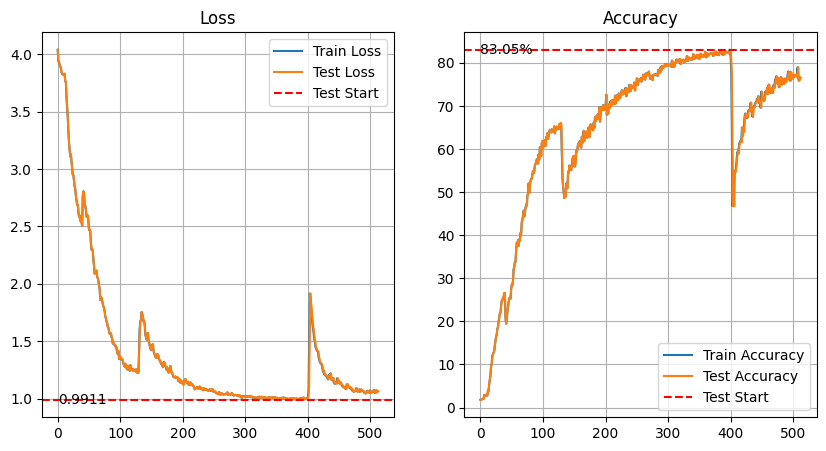

In [11]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc =  [stat[1] for stat in train_stats]
test_loss =  [stat[0] for stat in test_stats]
test_acc =   [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(np.min(test_loss), color='r', linestyle='--', label='Test Start')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(np.max(test_acc), color='r', linestyle='--', label='Test Start')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()
peak_accuracy = np.max(test_acc)

In [12]:
# !pip install seaborn

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s, loss=1.3233, acc=78.52%]


[EVAL] => Loss: 1.3474, Accuracy: 78.81%
[VALID] Loss: 1.3474, Accuracy: 78.81%
Confusion Matrix:
 [[  451     0     0 ...     0     0     0]
 [    0   837     0 ...     0     0     0]
 [   18     0   939 ...     0     0     0]
 ...
 [    0     0     0 ...  1163     0     0]
 [    0     0     0 ...     0  1549     0]
 [  405   399   363 ...   392   528 12953]]


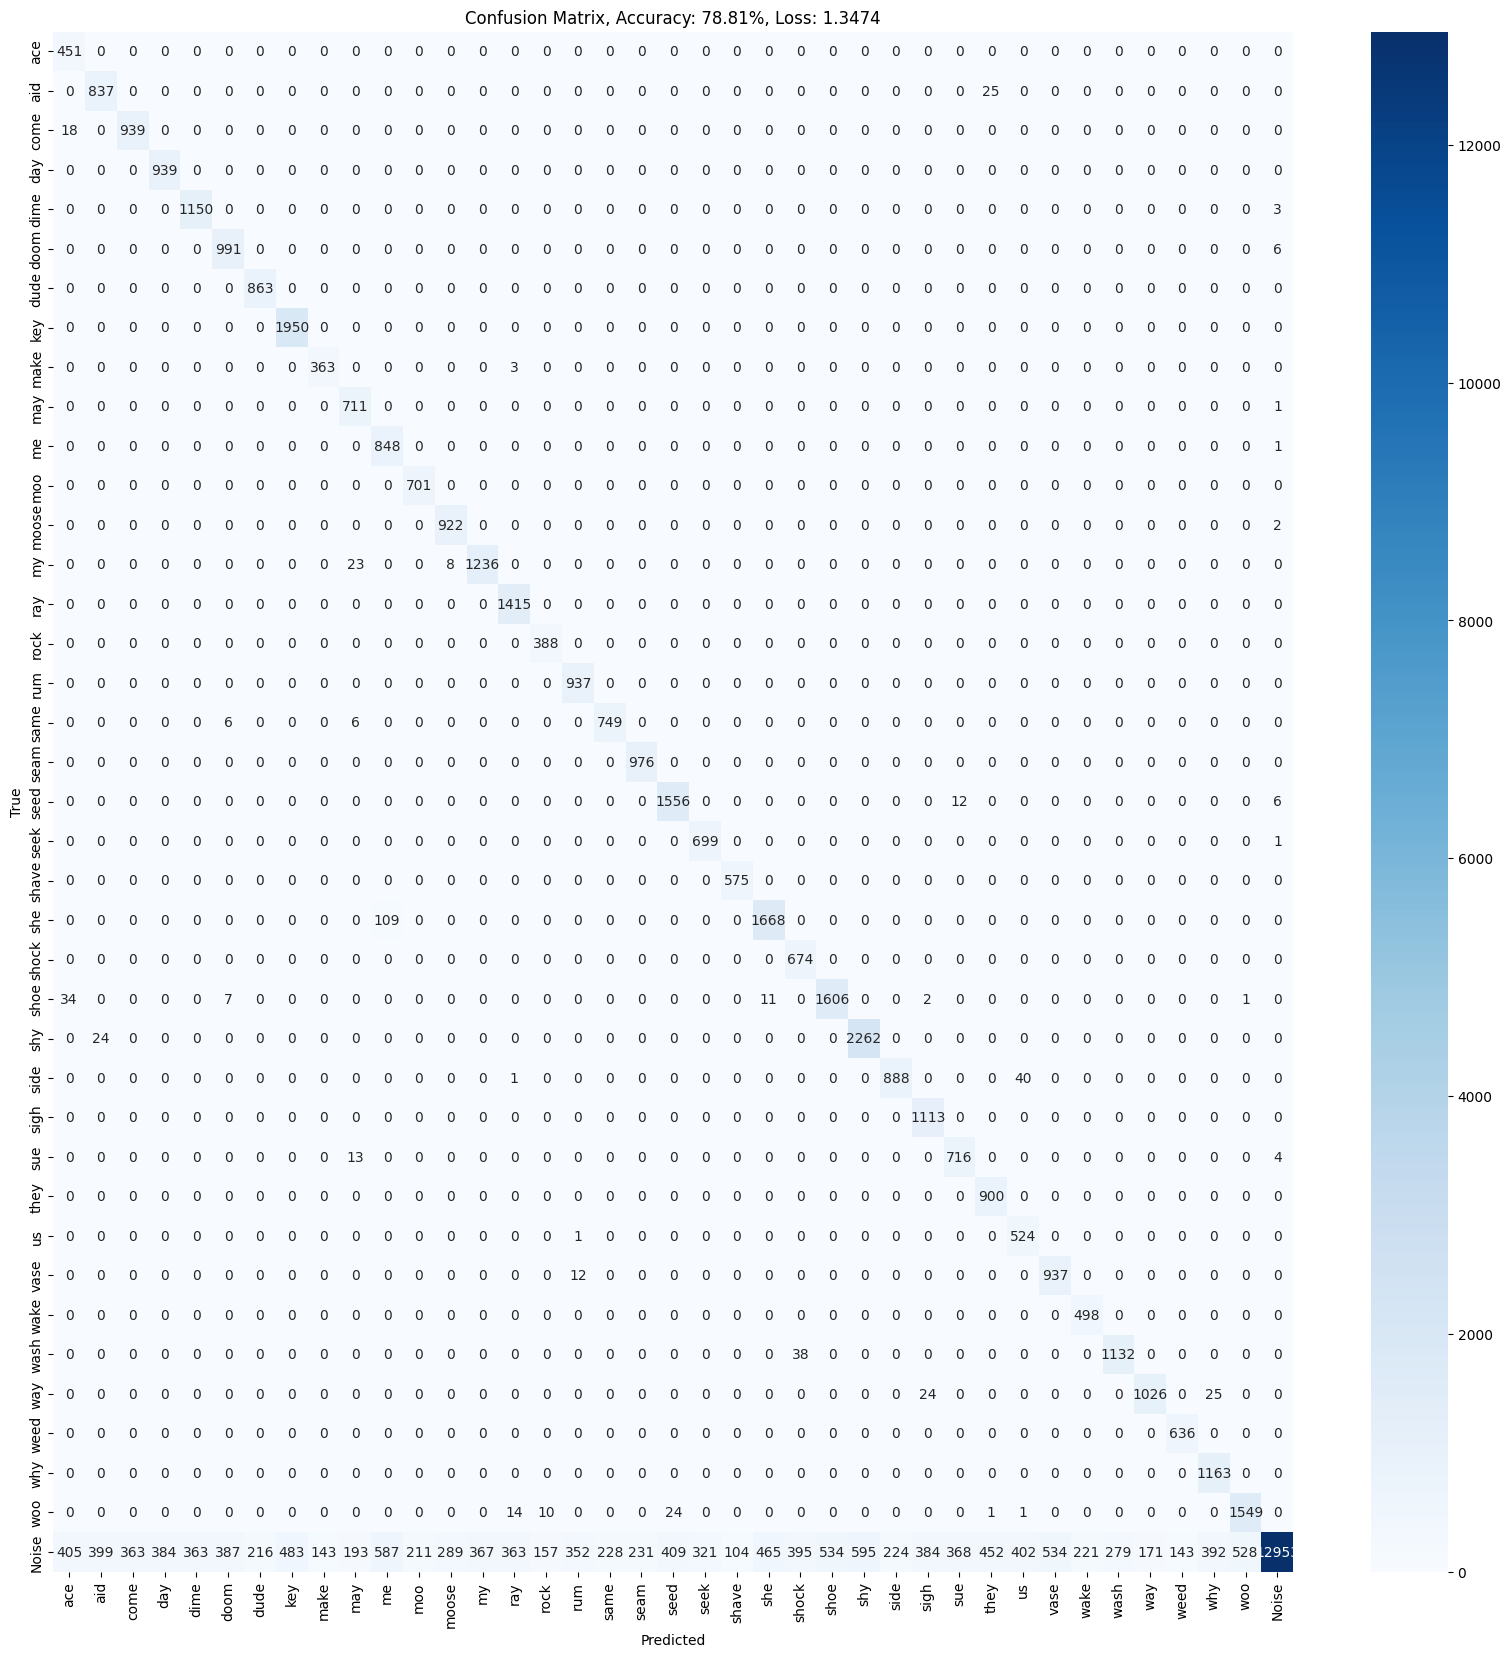

In [14]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_epoch(
    model,
    dataloader,
    dataset,  # used for `id_to_dataset()`
    device='cpu',
    verbose=1
):
    """
    Evaluate `model` for 1 epoch on `dataloader`, following the same strategy
    as the new training loop:

    - Downsample `ids` by `model.input_kern` (to match conv-downsampled length).
    - Forward pass on entire sequence to obtain [B, seq_len_after_conv, output_dim].
    - Compute cross-entropy loss on the entire output sequence.
    - Accumulate predictions vs. targets for final confusion matrix.
    - Return (avg_loss, accuracy, confusion_matrix).
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    num_batches = 0

    with torch.no_grad():
        iterator = tqdm(dataloader, desc="Evaluating", disable=(verbose == 0))
        for (adc1, adc2, ids) in iterator:
            # Move data to device
            adc1 = adc1.to(device)  # shape [B, T]
            adc2 = adc2.to(device)  # shape [B, T]
            ids  = ids.to(device)   # shape [B, T]

            # Downsample `ids` to match logits' length
            ids = ids[:, ::model.input_kern]  # shape [B, T_after_conv]

            # Prepare input: stack the two ADC channels => [B, 2, T]
            adc = torch.stack((adc1, adc2), dim=1)  # [B, 2, T]

            # Forward pass
            logits = model(adc)  # => [B, seq_len_after_conv, output_dim]

            # Compute loss
            loss = F.cross_entropy(
                logits.permute(0, 2, 1),  # => [B, output_dim, seq_len_after_conv]
                ids                       # => [B, seq_len_after_conv]
            )

            # Predictions & accuracy
            pred = logits.argmax(dim=2)  # => [B, seq_len_after_conv]
            correct = (pred == ids).sum().item()
            batch_tokens = ids.numel()

            total_loss += loss.item()
            total_correct += correct
            total_tokens += batch_tokens
            num_batches += 1

            # Accumulate for confusion matrix
            all_labels.extend(ids.view(-1).cpu().tolist())
            all_preds.extend(pred.view(-1).cpu().tolist())

            if verbose:
                iterator.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{100.0 * correct / batch_tokens:.2f}%"
                })

    # Final stats
    avg_loss = total_loss / max(num_batches, 1)
    accuracy = 100.0 * total_correct / total_tokens if total_tokens > 0 else 0.0

    # Build confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)

    if verbose:
        print(f"[EVAL] => Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy, conf_mat


# Example usage:
avg_loss, accuracy, conf_mat = evaluate_epoch(model, val_loader, dataset=dataset, device='cuda')
print(f"[VALID] Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
print("Confusion Matrix:\n", conf_mat)

# Build label names from your dataset
# Usually, you'd need the number of classes from something like `model.output_dim`,
# or from the shape of `conf_mat`. We'll assume conf_mat is square CxC, so:
num_classes = conf_mat.shape[0]
label_names = [dataset.id_to_dataset(i) for i in range(num_classes)]

# Plot the confusion matrix with class names
plt.figure(figsize=(20, 20))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title(f'Confusion Matrix, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
